# preparations

## Imports and utilities

In [241]:
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import HTML
from matplotlib import animation, rc

from skimage.color import rgb2gray
from skimage import data
from skimage.filters import gaussian
from skimage.segmentation import active_contour # For active_contour function

# For active_contour function
from skimage.segmentation import chan_vese, morphological_chan_vese, checkerboard_level_set,morphological_geodesic_active_contour

# For some image filtering
from skimage.morphology import white_tophat, black_tophat, disk

import skimage.io

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"



In [242]:
def edge_map(img,sigma):
    blur = skimage.filters.gaussian(img,sigma)
    return skimage.filters.sobel(blur)

def edge_map2(img,sigma):
    blur = skimage.filters.gaussian(img,sigma)
    return skimage.filters.scharr(blur)

def subtract_background(image, radius=5, light_bg=False):
        str_el = disk(radius)
        if light_bg:
            return black_tophat(image, str_el)
        else:
            return white_tophat(image, str_el)


def define_initial_circle(R0,r0,c0,Nber_pts=400):
    # Define initial contour shape
    s      = np.linspace(0, 2*np.pi, Nber_pts)
    Radius = R0
    r      = r0 + Radius*np.sin(s)
    c      = c0 + Radius*np.cos(s) #col
    init   = np.array([r, c]).T
    return init


## Create slides for animation
def animate_cv(image, segs, interval=1000):
    fig, ax = plt.subplots(figsize=(8, 8))
    ax.imshow(image, cmap='gray');
    im = ax.imshow(segs[0], alpha=0.5, cmap='inferno');
    ax.axis('off')

    def init():
        im.set_data(segs[0])
        return [im]

    def animate(i):
        im.set_array(segs[i])
        return [im]

    anim = animation.FuncAnimation(fig, animate, init_func=init,
                                   frames=len(segs), interval=1000, blit=True);
    return anim


def animate_snake(image, segs, interval=500):
    fig, ax = plt.subplots(figsize=(6, 6))
    ax.imshow(image, cmap='gray');
    #    im = ax.imshow(segs[0], alpha=0.5, cmap='inferno');
    #ax.plot(segs[0][:, 1], segs[0][:, 0], '--r', lw=3)
    ax.axis('off')
    line, = ax.plot([], [], '-r', lw=2)

    def init():
        line.set_data(segs[0,:,1],segs[0,:,0])
        return [line,]

    def animate(i):
        line.set_data(segs[i,:,1],segs[i,:,0])
        return [line,]

    anim = animation.FuncAnimation(fig, animate, init_func=init,
                                   frames=len(segs), interval=1000, blit=True);
    return anim



###########################
def store_evolution_in(lst):
    """Returns a callback function to store the evolution of the level sets in
    the given list.
    """

    def _store(x):
        lst.append(np.copy(x))

    return _store

## Read images

This cell reads a series of images that you can then use in various tests. <br>
Note that some images are provided with ground-truth masks of structures of interest:<br>
1. OCT_myocardium/case272.tif [one image]
2. images_blood_cells/000016.png [several images available]


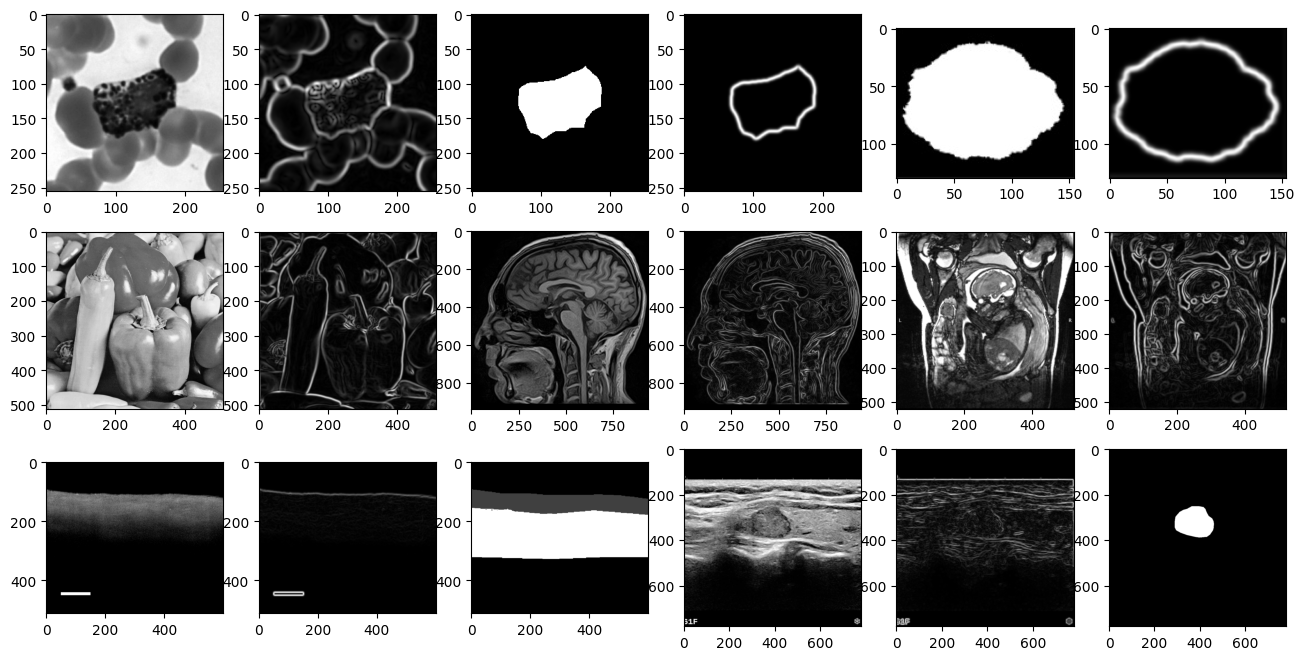

In [243]:
# import warnings
# warnings.filterwarnings( "ignore", module = "matplotlib\..*" )

img_star          = skimage.io.imread('./images_misc/smooth_star.png', as_gray = True)
img_star_noisy    = skimage.io.imread('./images_misc/smooth_star_noisy.png', as_gray = True)

img_hela    = skimage.io.imread('./images_misc/hela_big_gt.png', as_gray = False)

edge_hela   = edge_map(img_hela, sigma=2)
img_hela = np.squeeze(img_hela)

img_pepper  = skimage.io.imread('./images_misc/peppers_gt.png', as_gray = False)
img_pepper = np.squeeze(img_pepper)

edge_pepper = edge_map(img_pepper, sigma=2)
img_pepper  = img_pepper.astype('float64')




img_MRIb  = skimage.io.imread('./images_misc/MRI_brain_sag.png', as_gray = True)
edge_MRIb = edge_map(img_MRIb, sigma=2)
img_MRIf  = skimage.io.imread('./images_misc/MRI_fetus.png', as_gray = True)
edge_MRIf = edge_map(img_MRIf, sigma=2)


img_cell  = skimage.io.imread('./images_blood_cells/000016.png', as_gray = True)
edge_cell = edge_map(img_cell, sigma=2)
#skimage.io.imshow(img_cell)

img_mask = skimage.io.imread('./masks_blood_cells/000016.png', as_gray = True)
edge_mask = edge_map(img_mask, sigma=2)
img_mask2 = skimage.io.imread('./images_misc/binary_shape_2024.png', as_gray = True)
edge_mask2 = edge_map(img_mask2, sigma=2)
# skimage.io.imshow(img_mask)

img_OCT  = skimage.io.imread('./OCT_myocardium/case272.tif', as_gray = True)
edge_OCT = edge_map(img_OCT, sigma=2)
labels_OCT = skimage.io.imread('./OCT_myocardium/case272_label.tiff', as_gray = True)


img_nodule = skimage.io.imread('./thyroid_nodule/1074.png', as_gray = True)
edge_nodule = edge_map(img_nodule, sigma=2)
labels_nodule = skimage.io.imread('./thyroid_nodule/1074_mask.png', as_gray = True)


fig, axes = plt.subplots(3,6, figsize=(16, 8))
ax = axes.ravel()
ax[0].imshow(img_cell, cmap=plt.cm.gray);
ax[1].imshow(edge_cell, cmap=plt.cm.gray);
ax[2].imshow(img_mask, cmap=plt.cm.gray);
ax[3].imshow(edge_mask, cmap=plt.cm.gray);
ax[4].imshow(img_mask2, cmap=plt.cm.gray);
ax[5].imshow(edge_mask2, cmap=plt.cm.gray);

ax[6].imshow(img_pepper, cmap=plt.cm.gray);
ax[7].imshow(edge_pepper, cmap=plt.cm.gray);
ax[8].imshow(img_MRIb, cmap=plt.cm.gray);
ax[9].imshow(edge_MRIb, cmap=plt.cm.gray);
ax[10].imshow(img_MRIf, cmap=plt.cm.gray);
ax[11].imshow(edge_MRIf, cmap=plt.cm.gray);
ax[12].imshow(img_OCT, cmap=plt.cm.gray);
ax[13].imshow(edge_OCT, cmap=plt.cm.gray);
ax[14].imshow(labels_OCT, cmap=plt.cm.gray);
ax[15].imshow(img_nodule, cmap=plt.cm.gray);
ax[16].imshow(edge_nodule, cmap=plt.cm.gray);
ax[17].imshow(labels_nodule, cmap=plt.cm.gray);

## Image properties:
## Range of values and data type matter ...


Some routines won't work if your image type is int8 or uint8...
Here is how to check your image data type

And regularly check your image content in terms of:
* intensities range of values
* distributions of intensities via its histogram


float64
0.04579333333333333
0.8641733333333333


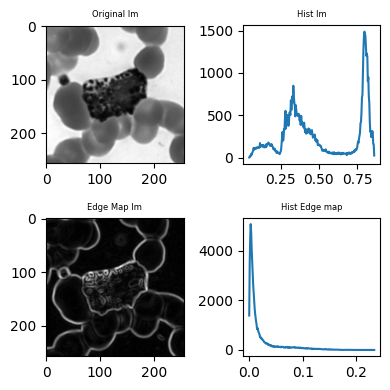

In [244]:

img_test  = img_cell
Sigma_val = 1
edge_test = edge_map(img_test, sigma=Sigma_val)


## Print some basic image properties
print(img_test.dtype)
print(np.min(img_test))
print(np.max(img_test))

#print(np.max(img_pepper))


## Show Hist
hist_test, bins_test             = np.histogram(img_test.flatten(), bins=256)
hist_edge_test, bins_edges_test  = np.histogram(edge_test.flatten(), bins=256)

fig, axes = plt.subplots(2,2, figsize=(4, 4))
ax        = axes.ravel()
ax[0].imshow(img_test, cmap=plt.cm.gray);
ax[0].set_title("Original Im", fontsize=6);
ax[1].plot(bins_test[0:-1],hist_test);
ax[1].set_title("Hist Im", fontsize=6);
ax[2].imshow(edge_test, cmap=plt.cm.gray);
ax[2].set_title("Edge Map Im", fontsize=6);
ax[3].plot(bins_edges_test[0:-1],hist_edge_test);
ax[3].set_title("Hist Edge map", fontsize=6);
fig.tight_layout()
plt.show();



## Edge maps
Deformable models rely on edge maps. Most routines have their own strategy coded to compute the edge map.

* Edge maps usually involve smoothing of the image, to be robust to noise. Make sure you understand how this is controlled in the routine you use.
* Edge maps usually show pixels with high gradient magnitudes in white (high values)
* Most deformable model routines can be fed directly with an Edge Map rather than the original image as its input
* Some routine expect to be fed with an inverse edge map where high gradient locations have small values, to stop the contour via a velocity set to ~zero.

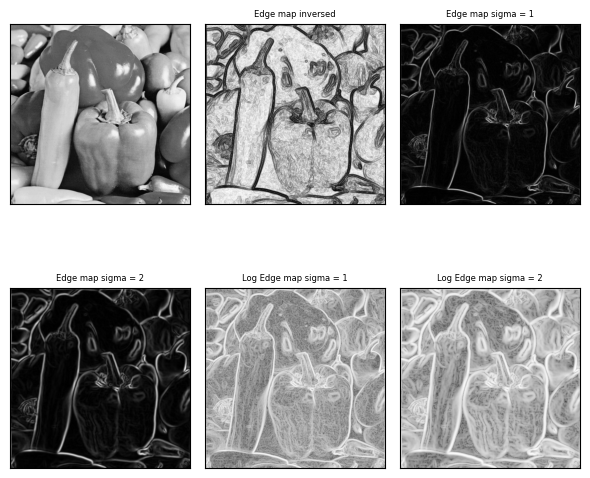

In [245]:

img_to_test = img_pepper

# Classic Edge map with Gaussian smoothing controled by sigma
edge_test1         = edge_map(img_to_test, sigma=1)
edge_test1_l       = np.log2(edge_test1)
edge_test2         = edge_map(img_to_test, sigma=2)
edge_test2_l       = np.log2(edge_test2)

# Inversed Edge map
# Returns Edge map = 1.0 / np.sqrt(1.0 + alpha * gradnorm)
edge_inv_test  = skimage.segmentation.inverse_gaussian_gradient(edge_test1, alpha=1.0, sigma=1.0)


fig, axes = plt.subplots(2,3, figsize=(6, 6))
ax = axes.ravel()

ax[0].imshow(img_to_test, cmap=plt.cm.gray);
ax[1].imshow(edge_inv_test, cmap=plt.cm.gray);
ax[1].set_title("Edge map inversed", fontsize=6);
ax[2].imshow(edge_test1, cmap=plt.cm.gray);
ax[2].set_title("Edge map sigma = 1", fontsize=6);
ax[3].imshow(edge_test2, cmap=plt.cm.gray);
ax[3].set_title("Edge map sigma = 2", fontsize=6);
ax[4].imshow(edge_test1_l, cmap=plt.cm.gray);
ax[4].set_title("Log Edge map sigma = 1", fontsize=6);
ax[5].imshow(edge_test2_l, cmap=plt.cm.gray);
ax[5].set_title("Log Edge map sigma = 2", fontsize=6);

for i in range(0,6):
    ax[i].set_xticks([]), ax[i].set_yticks([]);

fig.tight_layout()
plt.show();

## Test some image manipulations

Let you test some image transformations based on morphological operators and histogram manipulation.
When transforming image contrast, it is always interesting to look at the differences between the original image and the transformed version.

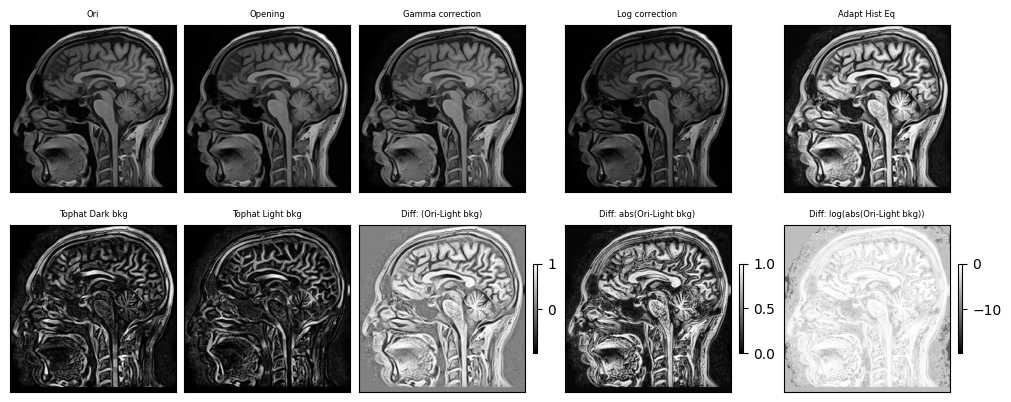

In [246]:
img_ori_to_test = img_MRIb
img_to_test     = img_ori_to_test
epsilon         = 0.000001 #to prevent log on 0
img_eps         = np.full_like(img_to_test, epsilon)
PRE_ENHANCE     = 1
OPTION_ENHANCE  = 4 # can be 0 (nothing) OR 1,2,3,4 for different enchancement options

# Run all  OPTION_ENHANCE for display here
gamma_corrected       = skimage.exposure.adjust_gamma(img_to_test, 0.8)
logarithmic_corrected = skimage.exposure.adjust_log(img_to_test, gain= 1,inv=True)
img_open              = skimage.morphology.diameter_opening(img_to_test, 40, connectivity=2)
img_adapteq           = skimage.exposure.equalize_adapthist(img_to_test, clip_limit=0.03)

# PRE ENHANCEMENT OPTIONS:
if PRE_ENHANCE==1:
    if OPTION_ENHANCE==1:
        # Gamma
        img_to_test     = gamma_corrected
    elif OPTION_ENHANCE==2:
        # Logarithmic (O = gain*log(1 + I)) or if Inv (O = gain*(2**I - 1))
        img_to_test           = logarithmic_corrected
    elif OPTION_ENHANCE==3:
        # Morpho Opening
        img_to_test           = img_open
    elif OPTION_ENHANCE==4:
        # Contrast Limited Adaptive Histogram Equalization (CLAHE).
        img_to_test           = img_adapteq

# Enhance details either dark around light background or vice versa with the Top-Hat transform
Radius_val = 15
img_test1  = subtract_background(img_to_test, radius=Radius_val, light_bg=False)
img_test2  = subtract_background(img_to_test, radius=Radius_val, light_bg=True)

# SHOW OUTPUTS
fig, axes = plt.subplots(2,5, figsize=(10, 4),constrained_layout=True)
ax        = axes.ravel()
Shrink_factor_colormap = 0.5
ax[0].imshow(img_ori_to_test, cmap=plt.cm.gray);
ax[0].set_title("Ori", fontsize=6);

ax[1].imshow(img_open, cmap=plt.cm.gray);
ax[1].set_title("Opening", fontsize=6);
ax[2].imshow(gamma_corrected, cmap=plt.cm.gray);
ax[2].set_title("Gamma correction", fontsize=6);
ax[3].imshow(logarithmic_corrected, cmap=plt.cm.gray);
ax[3].set_title("Log correction", fontsize=6);
ax[4].imshow(img_adapteq, cmap=plt.cm.gray);
ax[4].set_title("Adapt Hist Eq", fontsize=6);

ax[5].imshow(img_test1, cmap=plt.cm.gray);
ax[5].set_title("Tophat Dark bkg", fontsize=6);
ax[6].imshow(img_test2, cmap=plt.cm.gray);
ax[6].set_title("Tophat Light bkg", fontsize=6);

tmp_show = ax[7].imshow(img_to_test-img_test2, cmap=plt.cm.gray);
ax[7].set_title("Diff: (Ori-Light bkg)", fontsize=6);
plt.colorbar(tmp_show,ax=ax[7], shrink=Shrink_factor_colormap, location='right')

tmp_show = ax[8].imshow(abs(img_to_test-img_test2), cmap=plt.cm.gray);
ax[8].set_title("Diff: abs(Ori-Light bkg)", fontsize=6);
plt.colorbar(tmp_show,ax=ax[8], shrink=Shrink_factor_colormap, location='right')

tmp_show = ax[9].imshow(np.log2(abs(img_to_test-img_test2+img_eps)), cmap=plt.cm.gray);
ax[9].set_title("Diff: log(abs(Ori-Light bkg))", fontsize=6);
plt.colorbar(tmp_show,ax=ax[9], shrink=Shrink_factor_colormap, location='right')

for i in range(0,10):
    ax[i].set_xticks([]), ax[i].set_yticks([]);

#fig.tight_layout() # not compatible with option constrained_layout=True in plt.subplots needed to display the colorbar
plt.show();


# Seg #1:
### Snake on a binary shape

Based on the routine **active_contour** from skimage. <br>
Default **parameter values** are: <br>
* alpha=0.01  (Snake length shape parameter. Higher values makes snake contract faster.)
* beta=0.1    (Snake smoothness shape parameter. Higher values makes snake smoother.)
* gamma=0.01  (Explicit time stepping parameter - Equivalent to the viscosity of the environment)
* max_px_move=1.0
<br>

There are two **other parameters** that define the final image information used to define external forces used to define regions.img = w_line x img + w_edge x edge: <br>
*   w_line_val= 0 (default) | =1 if want to input_edge map directly. Use negative values to attract toward dark
*   w_edge_val= 1 (default)  | = 0 if do not want to use internal edge map. Use negative values to repel snake from edges


## TODO:
1. Run the cell for **img_to_seg=img_mask** and **img_to_seg=img_mask2** with the sets of parameter values provided. 1st set uses values by default, 2nd-3rd sets use custom values to help improve the smoothness of the final contour. <br>
    1. Comment on defaults seen on the obtained initial segmentations. <br>
    1. Explain why you think increasing the gamma_val has better helped smooth the final contour.  <br>

2. Test now by using a small initial circle inside the white shape. What is happening and what additional force seen in the class could help fixing this issue?

3. Now run the segmentation on the **img_to_seg=img_star** or **img_to_seg=img_star_noisy**. Try the same parameter values adjustments as before to get a smoother final contour. Comment on the issues observed with the two options.
4. BONUS: there is a way to obtain a "perfect" segmentation for the star shape. Propose one solution which might involve many more iterations, once you have checked with few iterations that behavior is stable.


## answer 1

Answers :
1-1 :
The parametric active countour algorithm (snake algorithm) is able to give a good result ; the btained contour is very close to the desired solution with the proposed hyperparameters. In this algorithm we used the default values of w_line_val and w_edge_val. In the default case, a snake is an energy-minimizing spline guided by external constraint forces and influenced by image
forces that pull it toward features such as lines and edges. Snakes are active contour models: they lock onto nearby edges, localizing them accurately.
The energy to minimize has the following expression $E_{snake}= \int _0^1 E_{int}(v(s)) + E_{image}(v(s)) + E_{con}(v(s))ds$
where $E_{int}$ represents the internal energy of the spline due to bending, $E_{image} $gives rise to the image forces and $E_{con}$ represnet the external constraint forces.  

$E_{int}=(α(s){|v_s(s)|}^2+β(s){|v_{ss}(s)|}^2)/2$
The spline internal energy is composed of a first order term controlled by $α(s)$ and a second-order term controlled by $\beta (s)$. These two hyperparameters controlls the size and smoothess of the spline. We noitice aswell that by setting beta to zero we are allowing second order discontinuity and thus allowing the snakes to develop a corner.

$E{image}= w_{line}E_{line}+w_{edge}E_{edge}$

The default expression for each term of the energy function is :      

-$E_{line} = I(x,y)$ which is the image intensity itself. Depending on the sign of w_{line}, the snake will be attracted either to light lines or drak lines. By adding the other constraints, the snake will try to align itself with the lightest or drakest nearby conotour.

-$E_{edge} = -|\nabla I(x,y)|^2$ . with this term the snake is attracted to contours with large image gradients.


Finally, the default constraint forces in the active_contour function is 'periodic' meaning that the two ends of the snake are attached (penalization for the distance between these two ).

1-2 :
Increasing the value of gamma is the same as reducing the step size. In fact, we can understand the effect of gamma through the analogy with mechanics. From a mechanical point of view, gamma represents the velocity that can be viewed as the resistance to movement. The higher the value of gamma the higher the resistance to the movements the slower we advance. Here, it is the same thing. The snake when faced with higher values of gamma will change slower. Thus it will be able to capture more of the edge features at each step and be able to slowly adapt to it. In contrast, low values of gamma will cause higher changes which can lead to missing edge features.



### mask 1

In [247]:
# 1ST image
#img_to_seg=img_mask; r0 = 130; c0=125; R0 = 5

img_to_seg=img_mask; r0 = 130; c0=125; R0 = 60

alpha_vals = [0.01,0.01,0.01]
beta_vals  = [0.1,0.1,1]
gamma_vals = [0.01,0.1,0.01]
convergence_val = 1e-4
Niter_snake = 800

# Initialise contour
init = define_initial_circle(R0,r0,c0)

# Pre-smooth the image
Niter_smooth    = 1
img_to_seg      = gaussian(img_to_seg, Niter_smooth, preserve_range=False)

# Run active contour
snakes10= []
snakes_max =[]
for i in range (3):
  snake10 = active_contour(img_to_seg,
                        init, max_num_iter=10, convergence=convergence_val,
                          alpha=alpha_vals[i], beta=beta_vals[i], gamma=gamma_vals[i])
  snake_max = active_contour(img_to_seg,
                        init, max_num_iter=Niter_snake, convergence=convergence_val,
                            alpha=alpha_vals[i], beta=beta_vals[i], gamma=gamma_vals[i])
  snakes10.append(snake10)
  snakes_max.append(snake_max)

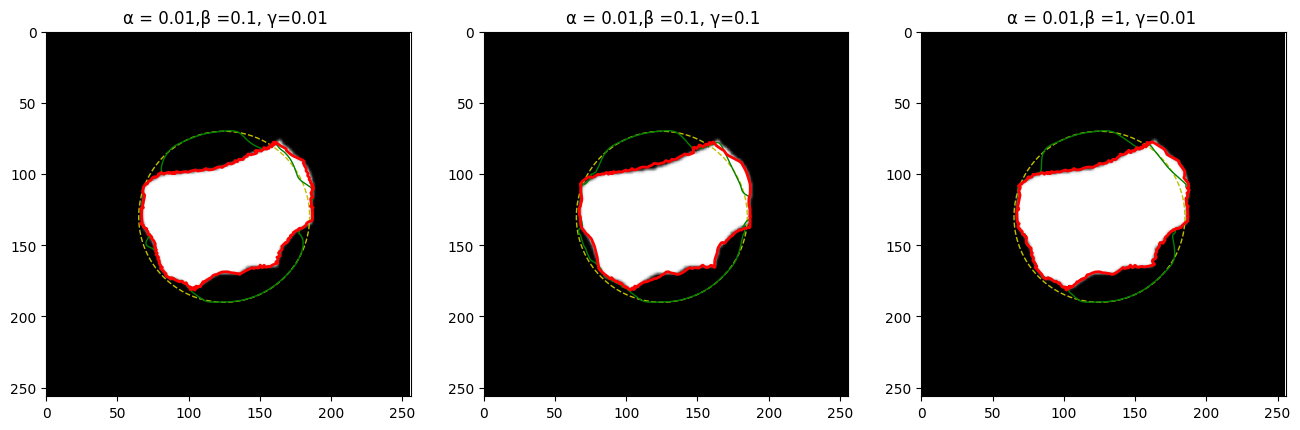

In [248]:
# Display results
fig, ax = plt.subplots(1,3,figsize=(16, 16));

for i in range (3):
  ax[i].imshow(img_to_seg, cmap=plt.cm.gray);
  ax[i].plot(init[:, 1], init[:, 0], '--y', lw=1);
  ax[i].plot(snakes10[i][:, 1], snake10[:, 0], '-g', lw=1);
  ax[i].plot(snakes_max[i][:, 1], snake_max[:, 0], '-r', lw=2);
  ax[i].axis([0, img_to_seg.shape[1], img_to_seg.shape[0], 0]);
  ax[i].set_title(f"α = {alpha_vals[i]},β ={beta_vals[i]}, γ={gamma_vals[i]} ")

plt.show();

### mask 2

In [249]:
# 1ST image
img_to_seg=img_mask2; r0 = 75; c0=65; R0 = 60
alpha_vals = [0.01,0.01,0.01]
beta_vals  = [0.1,0.1,1]
gamma_vals = [0.01,0.1,0.01]
convergence_val = 1e-4
Niter_snake = 800

# Initialise contour
init = define_initial_circle(R0,r0,c0)
# Initialise contour
Niter_smooth    = 1
img_to_seg      = gaussian(img_to_seg, Niter_smooth, preserve_range=False)

# Run active contour
snakes10= []
snakes_max =[]
for i in range (3):
  snake10 = active_contour(img_to_seg,
                        init, max_num_iter=10, convergence=convergence_val,
                          alpha=alpha_vals[i], beta=beta_vals[i], gamma=gamma_vals[i])
  snake_max = active_contour(img_to_seg,
                        init, max_num_iter=Niter_snake, convergence=convergence_val,
                            alpha=alpha_vals[i], beta=beta_vals[i], gamma=gamma_vals[i])
  snakes10.append(snake10)
  snakes_max.append(snake_max)


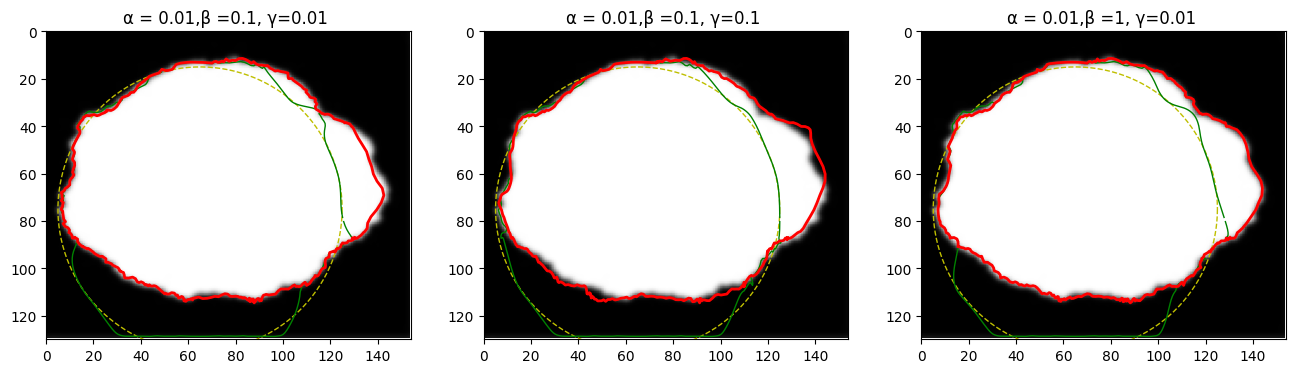

In [250]:
# Display results
fig, ax = plt.subplots(1,3,figsize=(16, 16));

for i in range (3):
  ax[i].imshow(img_to_seg, cmap=plt.cm.gray);
  ax[i].plot(init[:, 1], init[:, 0], '--y', lw=1);
  ax[i].plot(snakes10[i][:, 1], snake10[:, 0], '-g', lw=1);
  ax[i].plot(snakes_max[i][:, 1], snake_max[:, 0], '-r', lw=2);
  ax[i].axis([0, img_to_seg.shape[1], img_to_seg.shape[0], 0]);
  ax[i].set_title(f"α = {alpha_vals[i]},β ={beta_vals[i]}, γ={gamma_vals[i]} ")

plt.show();

## Answer 2

2- In this case, we have started with an intial circle inside the white area and we ended up with an even smaller circler that completly misses the desired edge. In fact, By doing this we have put our snake intially in an homogenous area. This means that the gradent is null and thus the external forces are null in this area. This causes the snake to only adapt to its internal forces since they are the ones that affects the energy function that we want to minimize, causing it to reduce its size while complety missing any forces that comes from the image. In order to deal with this scenario we can adopt an other model of external forces seen in our class which is the **Gradient vector Flow** (GVF). This model of external forces is basically a vctor field that preserve the gradient properties near the edges and diffuse these properties in homogeneous regions via "gradient diffusion". Thus giving the snake external foces even when normally the gradient of the image is null. Which will lead the snake to the desired contour.

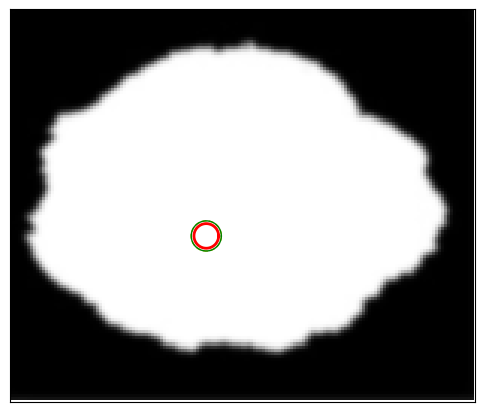

In [251]:
# 1ST image

img_to_seg=img_mask2; r0 = 75; c0=65; R0 = 5

alpha_val  = 0.01 ; beta_val = 1; gamma_val = 0.01; convergence_val = 1e-4; Niter_snake = 800;

# Initialise contour
init = define_initial_circle(R0,r0,c0)

# Pre-smooth the image
Niter_smooth    = 1
img_to_seg      = gaussian(img_to_seg, Niter_smooth, preserve_range=False)

# Run active contour
snake10 = active_contour(img_to_seg,
                       init, max_num_iter=10, convergence=convergence_val,
                         alpha=alpha_val, beta=beta_val, gamma=gamma_val)
snake_max = active_contour(img_to_seg,
                       init, max_num_iter=Niter_snake, convergence=convergence_val,
                           alpha=alpha_val, beta=beta_val, gamma=gamma_val)

# Display results
fig, ax = plt.subplots(figsize=(6, 6));
ax.imshow(img_to_seg, cmap=plt.cm.gray);
ax.plot(init[:, 1], init[:, 0], '--y', lw=1);
ax.plot(snake10[:, 1], snake10[:, 0], '-g', lw=1);
ax.plot(snake_max[:, 1], snake_max[:, 0], '-r', lw=2);
ax.set_xticks([]), ax.set_yticks([]);
ax.axis([0, img_to_seg.shape[1], img_to_seg.shape[0], 0]);

plt.show();

## Answer 3

In the case of the star image without noise, we noitice that after trying out the same set of parameters as before that we get bad results for the second set of paramters. This can be explained by the high value of gamma compared to the ther two. In fact, high value of gamma leads to low snake variation and in our caase 800 iteration won't be enough for convergence which explains the indequate somution. For the other two images we noitice that image with higher value of beta is more accurate. This is due to the process of reaching the contour for our situtation : since we are only relying on the gradient of the image in the external forces we noitice that if part of a snake finds a low-energy image feature, the spline term will pull neighboring parts of the
snake toward a possible continuation of the feature. This effectively places a large energy well around a good local minimum. Thus the most infulencial paramter here is the beta value, and we want it to be high in order to ensure this forces attracts the snake to the contour. which explains the 3rd image. Finally, we noitice that in the 3rd image, we have a discontinuity in the contour. This is due to the fact, that the intial snake has low number of points. And this number cannot capture the star shape contour accuratly.


In the case of the noisy star image, we see that we have overall the same interpretation. However, we noitice that the results are even worse in the case of the first and second images. In fact, due to the presence of the noise and absence of the actual contour in most of the intial circle, the snake is being exposed to external forces that are mostly random. which leads it to deform in an forseeable way. In the case of the image 1 compared to image 3 we noitice that the beta value is deterimantal in this case. As explained before, the beta is the one leading the overall deformation of the snake in this type of scenarios.

### image star

In [252]:
# 2ND image
img_to_seg = img_star ; r0 = 64; c0=64; R0 = 50
#img_to_seg = img_star_noisy ; r0 = 64; c0=64; R0 = 50

# Initialise contour
init = define_initial_circle(R0,r0,c0)


alpha_vals = [0.01,0.01,0.01]
beta_vals  = [0.1,0.1,1]
gamma_vals = [0.01,0.1,0.01]
convergence_val = 1e-4
Niter_snake = 800

# Initialise contour
init = define_initial_circle(R0,r0,c0)

# Pre-smooth the image
Niter_smooth    = 1
img_to_seg      = gaussian(img_to_seg, Niter_smooth, preserve_range=False)

# Run active contour
snakes10= []
snakes_max =[]
for i in range (3):
  snake10 = active_contour(img_to_seg,
                        init, max_num_iter=10, convergence=convergence_val,
                          alpha=alpha_vals[i], beta=beta_vals[i], gamma=gamma_vals[i])
  snake_max = active_contour(img_to_seg,
                        init, max_num_iter=Niter_snake, convergence=convergence_val,
                            alpha=alpha_vals[i], beta=beta_vals[i], gamma=gamma_vals[i])
  snakes10.append(snake10)
  snakes_max.append(snake_max)


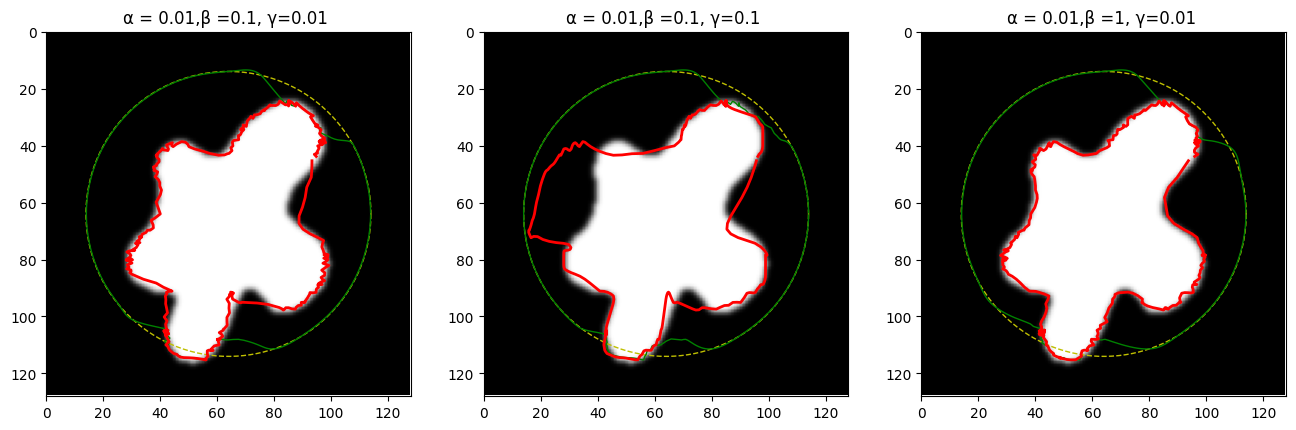

In [253]:
# Display results
fig, ax = plt.subplots(1,3,figsize=(16, 16));

for i in range (3):
  ax[i].imshow(img_to_seg, cmap=plt.cm.gray);
  ax[i].plot(init[:, 1], init[:, 0], '--y', lw=1);
  ax[i].plot(snakes10[i][:, 1], snake10[:, 0], '-g', lw=1);
  ax[i].plot(snakes_max[i][:, 1], snake_max[:, 0], '-r', lw=2);
  ax[i].axis([0, img_to_seg.shape[1], img_to_seg.shape[0], 0]);
  ax[i].set_title(f"α = {alpha_vals[i]},β ={beta_vals[i]}, γ={gamma_vals[i]} ")

plt.show();

### image star noisy

In [254]:

# 2ND image
img_to_seg = img_star_noisy ; r0 = 64; c0=64; R0 = 50

# Initialise contour
init = define_initial_circle(R0,r0,c0)


alpha_vals = [0.01,0.01,0.01]
beta_vals  = [0.1,0.1,1]
gamma_vals = [0.01,0.1,0.01]
convergence_val = 1e-4
Niter_snake = 800

# Initialise contour
init = define_initial_circle(R0,r0,c0)

# Pre-smooth the image
Niter_smooth    = 1
img_to_seg      = gaussian(img_to_seg, Niter_smooth, preserve_range=False)

# Run active contour
snakes10= []
snakes_max =[]
for i in range (3):
  snake10 = active_contour(img_to_seg,
                        init, max_num_iter=10, convergence=convergence_val,
                          alpha=alpha_vals[i], beta=beta_vals[i], gamma=gamma_vals[i])
  snake_max = active_contour(img_to_seg,
                        init, max_num_iter=Niter_snake, convergence=convergence_val,
                            alpha=alpha_vals[i], beta=beta_vals[i], gamma=gamma_vals[i])
  snakes10.append(snake10)
  snakes_max.append(snake_max)


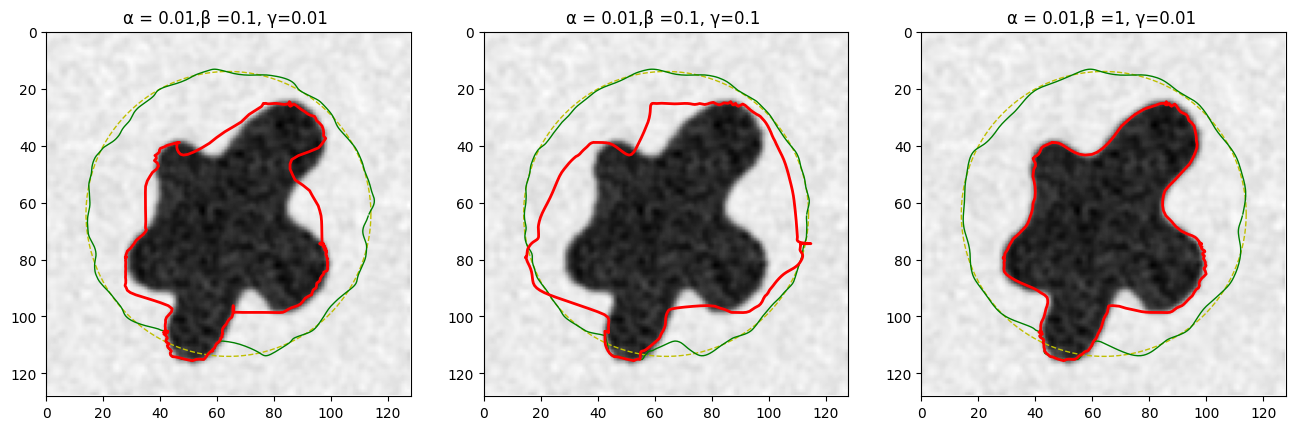

In [255]:
# Display results
fig, ax = plt.subplots(1,3,figsize=(16, 16));

for i in range (3):
  ax[i].imshow(img_to_seg, cmap=plt.cm.gray);
  ax[i].plot(init[:, 1], init[:, 0], '--y', lw=1);
  ax[i].plot(snakes10[i][:, 1], snake10[:, 0], '-g', lw=1);
  ax[i].plot(snakes_max[i][:, 1], snake_max[:, 0], '-r', lw=2);
  ax[i].axis([0, img_to_seg.shape[1], img_to_seg.shape[0], 0]);
  ax[i].set_title(f"α = {alpha_vals[i]},β ={beta_vals[i]}, γ={gamma_vals[i]} ")

plt.show();

## Answer 4

The idea is to apply the active contour model on the image in multiscales. First we start by applying gaussian filter with high sigma value and get the snake contour, afterwards we use this snake as intialization for the image after applying an other gaussian filter with lower sigma until we hit sigma = 1. In theory this will allow us to get smooth contours and adjest them until we get our target. The obtained results are much better than perviously

In [256]:

#img_to_seg = img_star ; r0 = 64; c0=64; R0 = 50
#img_to_seg = img_star_noisy ; r0 = 64; c0=64; R0 = 50
img_to_seg = img_star
# Initialise contour
inits = [define_initial_circle(R0,r0,c0,700),define_initial_circle(R0,r0,c0,700),define_initial_circle(R0,r0,c0,700)]


alpha_vals = [0.01,0.01,0.01]
beta_vals  = [1,5,10]
gamma_vals = [0.01,0.01,0.01]
convergence_val = 1e-4
Niter_snake = 800

# Initialise contour
init =snakes_max[2]

Niter_smooth    = 1
img_to_seg      = gaussian(img_to_seg, Niter_smooth, preserve_range=False)

# Run active contour
snakes10= []
snakes_max =[]
for i in range (3):
  snake10 = active_contour(img_to_seg,
                        init, max_num_iter=10, convergence=convergence_val,
                          alpha=alpha_vals[i], beta=beta_vals[i], gamma=gamma_vals[i])
  snake_max = active_contour(img_to_seg,
                        init, max_num_iter=Niter_snake, convergence=convergence_val,
                            alpha=alpha_vals[i], beta=beta_vals[i], gamma=gamma_vals[i])
  snakes10.append(snake10)
  snakes_max.append(snake_max)


In [257]:
# 2ND image
img_to_seg = img_star ; r0 = 64; c0=64; R0 = 50
#img_to_seg = img_star_noisy ; r0 = 64; c0=64; R0 = 50

alpha_val = 0.01
beta_val  = 1
gamma_val =0.01
convergence_val = 1e-4
Niter_snake = 1600

# Initialise contour
init = define_initial_circle(R0,r0,c0)
inits=[init]
# Pre-smooth the image
Niters_smooth    = [10,8,6,4,2,1]
snakes_10 =[]
snakes_max =[]
for i in range (len (Niters_smooth)):

      img_to_seg      = gaussian(img_star, Niters_smooth[i], preserve_range=False)

      # Run active contour
      snake10 = active_contour(img_to_seg,
                              init, max_num_iter=10, convergence=convergence_val,
                                alpha=alpha_val, beta=beta_val, gamma=gamma_val)
      snake_max = active_contour(img_to_seg,
                              init, max_num_iter=Niter_snake, convergence=convergence_val,
                                  alpha=alpha_val, beta=beta_val, gamma=gamma_val)
      snakes10.append(snake10)
      snakes_max.append(snake_max)
      init = snake_max
      inits.append(init)


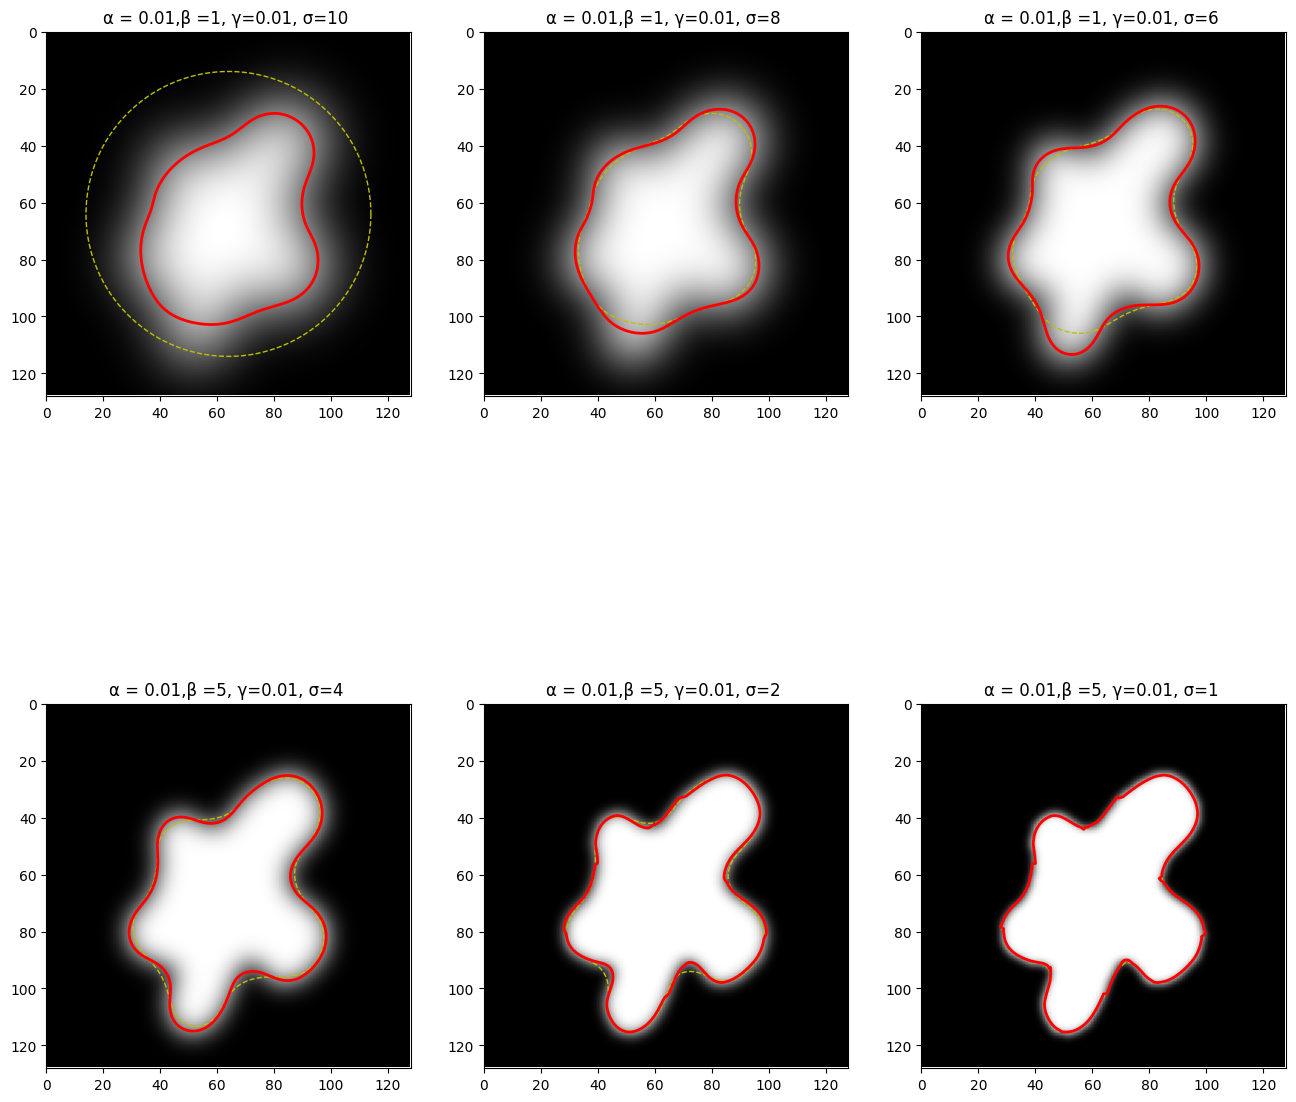

In [258]:
# Display results
fig, ax = plt.subplots(2,3,figsize=(16, 16));

for i in range (2):
  for j in range(3):
    ax[i,j].imshow(gaussian(img_to_seg, Niters_smooth[3*i+j], preserve_range=False), cmap=plt.cm.gray);
    ax[i,j].plot(inits[3*i+j][:, 1], inits[3*i+j][:, 0], '--y', lw=1);
    #ax[i,j].plot(snakes10[3*i+j][:, 1], snakes10[3*i+j][:, 0], '-g', lw=1);
    ax[i,j].plot(snakes_max[3*i+j][:, 1], snakes_max[3*i+j][:, 0], '-r', lw=2);
    ax[i,j].axis([0, img_to_seg.shape[1], img_to_seg.shape[0], 0]);
    ax[i,j].set_title(f"α = {alpha_vals[i]},β ={beta_vals[i]}, γ={gamma_vals[i]}, σ={Niters_smooth[3*i+j]} ")

plt.show();

Finally we show the intial input (the yellow cercle) and the final snake (in red) of our procedure. with even better parameters and more iterations we can get the perfect contour.

(0.0, 128.0, 128.0, 0.0)

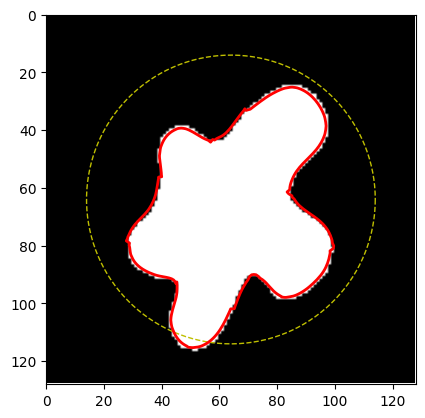

In [259]:
plt.imshow(img_star, cmap=plt.cm.gray);
plt.plot(inits[0][:, 1], inits[0][:, 0], '--y', lw=1);
plt.plot(snakes_max[-1][:, 1], snakes_max[-1][:, 0], '-r', lw=2);
plt.axis([0, img_to_seg.shape[1], img_to_seg.shape[0], 0]);
plt.show()

# Seg #2:
### Snake on a real image

We are using here **img_to_seg   = img_cell** for which you have a ground truth mask of the target segmentation for the dark cell.  

## TODO
1. **Segment left cell**:
    1. Run with the proposed initialisation and see that the active contour can be initialised inside the object. Give some intuition on why.
2. **Segment right cell**:
    1. Run with the proposed initialisation and see that the active contour cannot be initialised inside the object now. Give some intuition on why.
    2. Change the parameter **Niter_smooth** while keeping snake parameters constant and give an intuition on why the final contour evolves as seen.
    1. Change the initial contour parameters to obtain a perfect segmentation.
3. BONUS: If you know that you are aiming for the darkest cell in the image, propose an automated initialisation of the initial active contour parameters [r0 ; c0; R0 ] that works on this image.



## Answer 1

With this intialisation we get a good segmentation ofthe left cell. This is due to two phenomena:
* The intial circle intersects the desired contour: This leads the snake to defrome in the intersection point in order to minimize the external energy due to the grad near this points.
* The intial circle was close to the contour : we can noitice this in the left side of the circle in particular. Due to the gaussien filter, the edge will influence more regions near it. This will lead to more wide range of influence of the external forces. This explains why the snake in that area was attracted to the contour (the bleu circle found the desired target)

It is important to add that the cell is represented in the image as an homogenous area where the inside was smooth. This leads to very low gradient inside the cell (practically null). This allows the snake to be only influenced by the actual contours.


In [260]:

# Input image and parameter values
img_to_seg   =  img_cell;

# 1st SEG: To segment left cell
r0 = 150; c0=50; R0 = 30
alpha_val = 0.01 ; beta_val = 0.1 ;gamma_val = 0.01;
convergence_val = 1e-4; Niter_snake = 200;

# Pre smooth the image
Niter_smooth = 1
img_to_seg   = gaussian(img_to_seg, Niter_smooth, preserve_range=False)

# Initialise contour
init = define_initial_circle(R0,r0,c0)

# Run active contour
snake30 = active_contour(img_to_seg,
                       init, max_num_iter=30, convergence=convergence_val,
                         alpha=alpha_val, beta=beta_val, gamma=gamma_val)
snake = active_contour(img_to_seg,
                       init, max_num_iter=Niter_snake, convergence=convergence_val,
                       alpha=alpha_val, beta=beta_val, gamma=gamma_val)

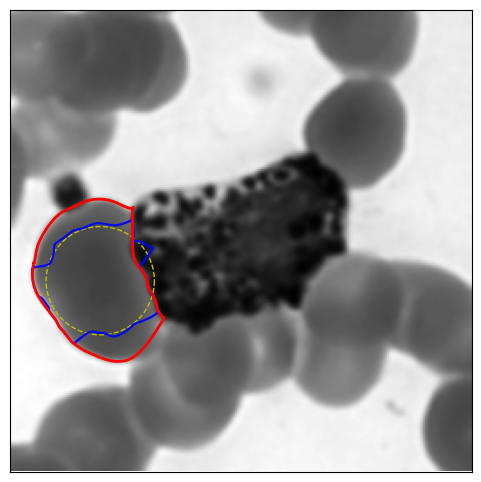

In [261]:
# Display results
fig, ax = plt.subplots(figsize=(6, 6))
ax.imshow(img_to_seg, cmap=plt.cm.gray)
ax.plot(init[:, 1], init[:, 0], '--y', lw=1)
ax.plot(snake30[:, 1], snake30[:, 0], '-b', lw=1.5)
ax.plot(snake[:, 1], snake[:, 0], '-r', lw=2)
ax.set_xticks([]), ax.set_yticks([])
ax.axis([0, img_to_seg.shape[1], img_to_seg.shape[0], 0])

plt.show();

## Answer 2

### 1

In this case we no longer have an intialization that intersects the contour, nor close to it nor a smooth region area. In fact, the inside of the right cell is a non-homogenous area where we have high variations. This lead to high gradient values that create high external forces that doesn't correspond to actual contours. This will constraint the snake to undesired strong forces and thus leading it to undesired results

In [262]:
# Input image and parameter values
img_to_seg   =  img_cell;

# 2nd SEG: To segment center dark cell
r0 = 130; c0=120; R0 = 30
alpha_val = 0.01 ; beta_val = 0.1 ;gamma_val = 0.01;
convergence_val = 1e-4; Niter_snake = 800;

# Pre smooth the image
Niter_smooth = 1
img_to_seg   = gaussian(img_to_seg, Niter_smooth, preserve_range=False)

# Initialise contour
init = define_initial_circle(R0,r0,c0)

# Run active contour
snake30 = active_contour(img_to_seg,
                       init, max_num_iter=30, convergence=convergence_val,
                         alpha=alpha_val, beta=beta_val, gamma=gamma_val)
snake = active_contour(img_to_seg,
                       init, max_num_iter=Niter_snake, convergence=convergence_val,
                       alpha=alpha_val, beta=beta_val, gamma=gamma_val)

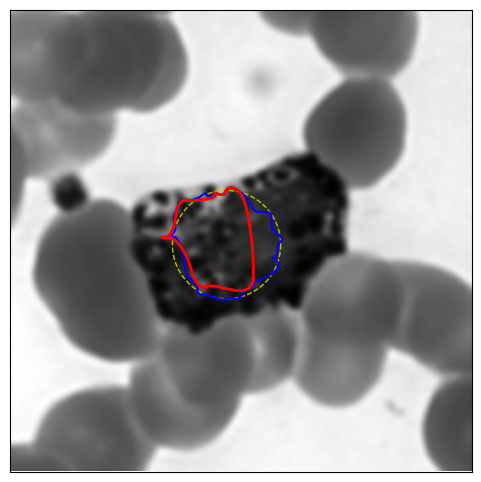

In [263]:
# Display results
fig, ax = plt.subplots(figsize=(6, 6))
ax.imshow(img_to_seg, cmap=plt.cm.gray)
ax.plot(init[:, 1], init[:, 0], '--y', lw=1)
ax.plot(snake30[:, 1], snake30[:, 0], '-b', lw=1.5)
ax.plot(snake[:, 1], snake[:, 0], '-r', lw=2)
ax.set_xticks([]), ax.set_yticks([])
ax.axis([0, img_to_seg.shape[1], img_to_seg.shape[0], 0])

plt.show();

### 2

In this case, we chose a high value of sigma (6) this leads to bigger gaussien kernel that affects more areas around the pixel.
This leads to smoother regions. Thus the fluctuations inside the right cell are less important and the snake is able to reach the external contours (some of them). This can be further enhanced by adjusting the values of beta and alpha in order to tolerate bigger shapes and irregular curvature or change the intial shape parameters in order to be closer to the desired solution

In [264]:
# Input image and parameter values
img_to_seg   =  img_cell;

# 2nd SEG: To segment center dark cell
r0 = 130; c0=120; R0 = 30
alpha_val = 0.01 ; beta_val = 0.1 ;gamma_val = 0.01;
convergence_val = 1e-4; Niter_snake = 800;

# Pre smooth the image
Niter_smooth = 8
img_to_seg   = gaussian(img_to_seg, Niter_smooth, preserve_range=False)

# Initialise contour
init = define_initial_circle(R0,r0,c0)

# Run active contour
snake30 = active_contour(img_to_seg,
                       init, max_num_iter=30, convergence=convergence_val,
                         alpha=alpha_val, beta=beta_val, gamma=gamma_val)
snake = active_contour(img_to_seg,
                       init, max_num_iter=Niter_snake, convergence=convergence_val,
                       alpha=alpha_val, beta=beta_val, gamma=gamma_val)

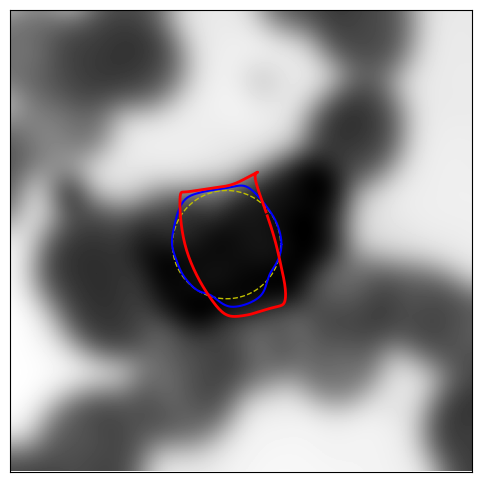

In [265]:
# Display results
fig, ax = plt.subplots(figsize=(6, 6))
ax.imshow(img_to_seg, cmap=plt.cm.gray)
ax.plot(init[:, 1], init[:, 0], '--y', lw=1)
ax.plot(snake30[:, 1], snake30[:, 0], '-b', lw=1.5)
ax.plot(snake[:, 1], snake[:, 0], '-r', lw=2)
ax.set_xticks([]), ax.set_yticks([])
ax.axis([0, img_to_seg.shape[1], img_to_seg.shape[0], 0])

plt.show();

### 3

A solution consists in changing the raduis of the intial circle in order to be closer to the desired solution.

In [266]:
# Input image and parameter values
img_to_seg   =  img_cell;

# 2nd SEG: To segment center dark cell
r0 = 130; c0=120; R0 = 50
alpha_val = 0.01 ; beta_val = 0.1 ;gamma_val = 0.01;
convergence_val = 1e-4; Niter_snake = 800;

# Pre smooth the image
Niter_smooth = 8
img_to_seg   = gaussian(img_to_seg, Niter_smooth, preserve_range=False)

# Initialise contour
init = define_initial_circle(R0,r0,c0)

# Run active contour
snake30 = active_contour(img_to_seg,
                       init, max_num_iter=30, convergence=convergence_val,
                         alpha=alpha_val, beta=beta_val, gamma=gamma_val)
snake = active_contour(img_to_seg,
                       init, max_num_iter=Niter_snake, convergence=convergence_val,
                       alpha=alpha_val, beta=beta_val, gamma=gamma_val)

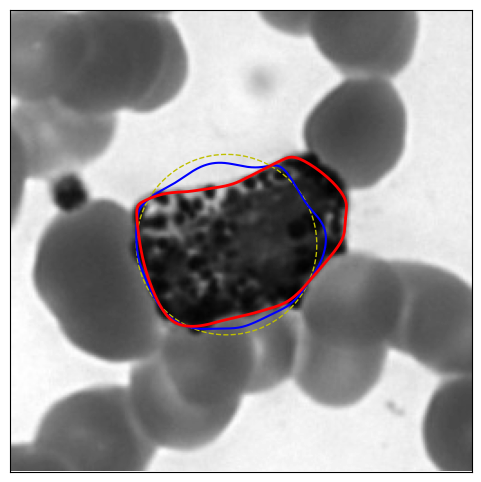

In [267]:
# Display results
fig, ax = plt.subplots(figsize=(6, 6))
ax.imshow(img_cell, cmap=plt.cm.gray)
ax.plot(init[:, 1], init[:, 0], '--y', lw=1)
ax.plot(snake30[:, 1], snake30[:, 0], '-b', lw=1.5)
ax.plot(snake[:, 1], snake[:, 0], '-r', lw=2)
ax.set_xticks([]), ax.set_yticks([])
ax.axis([0, img_to_seg.shape[1], img_to_seg.shape[0], 0])

plt.show();

### 3-Bonus

The idea is the following : First, we will use our prior knowledge on the image to determin the range of values that the darkest cell can take. We will then use this range in order to get an estimate of the segmentation for the dark cell. This segmentation doesn't need to be accurate nor precise. It can contain some outlayers as well. However it must contain in majority the pixels of the darkest cells. Then, after obtaining the intial estimate of the segmentation. We can determin the center of the intial circle by median value of all the segmented pixel coordinates (to be robust to outlayers) and then we will compute the distances of all the segmented pixels to this center and use the 90-percentile value as the intial circle raduis.


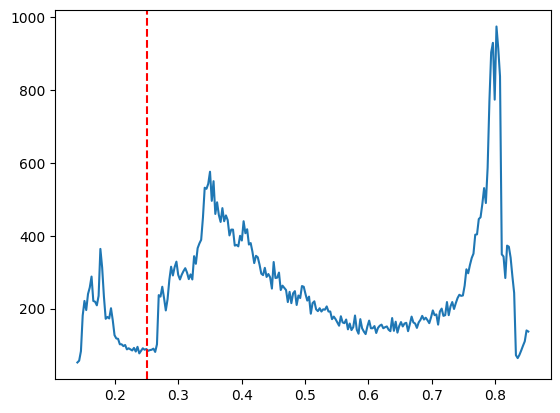

In [268]:
#determining the range of values for the darkest cell
bins,hist = np.histogram(img_to_seg.flatten(),bins=256)
plt.plot(hist[:-1],bins)
plt.axvline(x=0.25, color='r', linestyle='--')

In [269]:
#determining the center of the circle and the raduis
def get_inital_circl_param (img_to_seg,max_gray_level=0.25,percentile=90) :
  coordinates = np.vstack(np.where((img_to_seg<max_gray_level)))
  r0,c0 = np.median(coordinates,axis=1)
  distances2 = np.sqrt((coordinates.T - np.array( [r0,c0]))**2)
  R0 = np.percentile(distances2,percentile)
  return r0,c0,R0

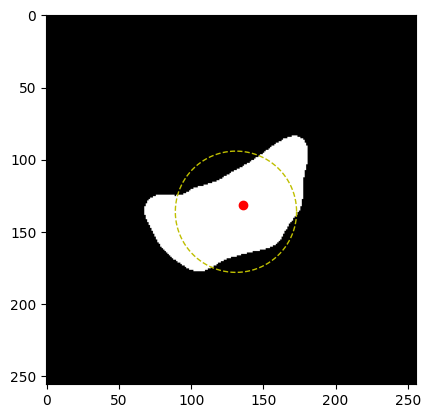

In [270]:
r0,c0,R0 = get_inital_circl_param (img_to_seg)
init = define_initial_circle(R0,r0,c0)
plt.imshow((img_to_seg<0.25),cmap='gray')
plt.plot(r0,c0,'-r',marker='o')
plt.plot(init[:, 1], init[:, 0], '--y', lw=1)
plt.show()

Now let's try out our algorithm on the intial image

In [271]:
# Input image and parameter values
img_to_seg   =  img_cell;

# 2nd SEG: To segment center dark cell
r0,c0,R0 = get_inital_circl_param (img_to_seg)
alpha_val = 0.01 ; beta_val = 0.1 ;gamma_val = 0.01;
convergence_val = 1e-4; Niter_snake = 1600;

# Pre smooth the image
Niter_smooth = 8
img_to_seg   = gaussian(img_to_seg, Niter_smooth, preserve_range=False)

# Initialise contour
init = define_initial_circle(R0,r0,c0)

# Run active contour
snake30 = active_contour(img_to_seg,
                       init, max_num_iter=30, convergence=convergence_val,
                         alpha=alpha_val, beta=beta_val, gamma=gamma_val)
snake = active_contour(img_to_seg,
                       init, max_num_iter=Niter_snake, convergence=convergence_val,
                       alpha=alpha_val, beta=beta_val, gamma=gamma_val)

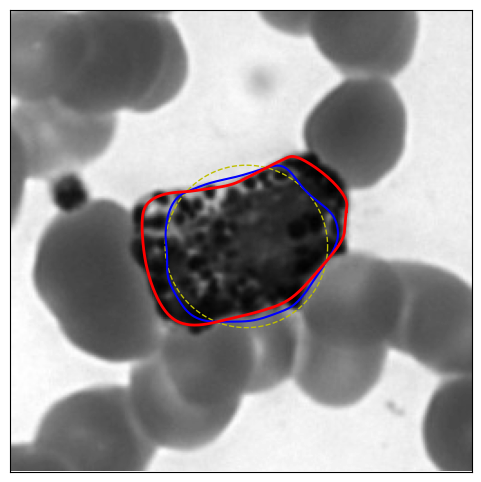

In [272]:
# Display results
fig, ax = plt.subplots(figsize=(6, 6))
ax.imshow(img_cell, cmap=plt.cm.gray)
ax.plot(init[:, 1], init[:, 0], '--y', lw=1)
ax.plot(snake30[:, 1], snake30[:, 0], '-b', lw=1.5)
ax.plot(snake[:, 1], snake[:, 0], '-r', lw=2)
ax.set_xticks([]), ax.set_yticks([])
ax.axis([0, img_to_seg.shape[1], img_to_seg.shape[0], 0])

plt.show();

# Seg # 3

### A tool to visualise the deformations of the snake


## TO DO:
1. **Segment left cell**:
    1. Provide your comments on the deformation pattern of the snake.
    1. Why iteration time steps get slower over iterations when initialising from the inside?
1. **Segment right cell**:
     1. Use your optimal parameters from previous cell and comment on the deformation patterns.

## Answer 1

### 1

The intial contour is a circle that is close enough to the boundary to be affected by the external forces coming from the gradient. The second frame (11th iteration ) shows that the snakes is attracted to the desired edge only in the left most and right most boundaries (near the dark cell). This is expected since these two parts are heavily affected by the external forces because they are near the the contours. Whereas the rest of the snake is mostly in a homogenous area. With each frame, we observe that the snake parts that falled into the right edge are being conserved and now that part is attracting the rest of the snake aswell due to the regularisation constraint and once close enough, it starts embracing the edge since get a local minima of the energy function like what happened in the first step. Thus, with each step the snake is able to become more and more close to the desired edge until finally, it reachs it, successfully giving us a local minima

start
1  11  21  31  41  51  61  71  81  91  101  111  121  131  141  151  161  171  181  191  stop


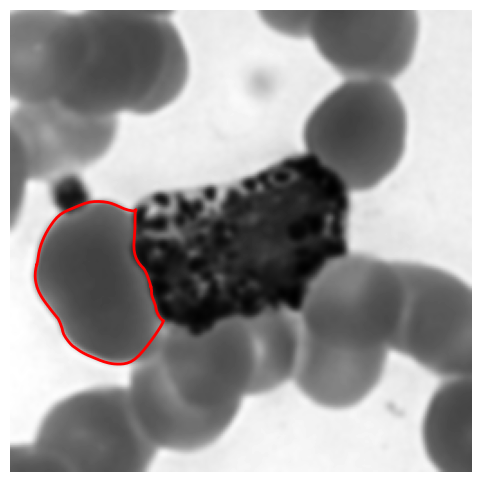

In [273]:
img_to_seg        = img_cell

# 1st SEG: To segment left cell
r0 = 150; c0=50; R0 = 30
alpha_val = 0.01 ; beta_val = 0.1 ;gamma_val = 0.01; convergence_val = 1e-4; Niter_snake = 200;

# Pre smooth the image
Niter_smooth = 1
img_to_seg   = gaussian(img_to_seg, Niter_smooth, preserve_range=False)

# Initialise contour
init = define_initial_circle(R0,r0,c0)

# Run active contour while saving intermediate contours to see deformations
segs = []
print('start')
for i in range(1,Niter_snake,10):
    print(i, " ", end='')
    segs.append(active_contour(img_to_seg, init, max_num_iter=i, convergence=convergence_val,
                alpha=alpha_val, beta=beta_val, gamma=gamma_val))

print('stop')
np.save('ANIM_contours.npy', np.array(segs))

# display animation
segs = np.load('ANIM_contours.npy')
anim = animate_snake(img_to_seg, segs);
HTML(anim.to_html5_video())

### 2

When intialized from inside the snake finds itself in a completly homegenous area and is submitted to the external forces only when the intialization is close enough to the contour. This means that for most part of the snake, the deformation results as a consequence of the regularisation term near its parts that found the edge and thus it is contrainted to adapt to the desired solution step by step. Here in the next cell I tried to start with a smaller circl inside the cell to prove that when we have a little part of the snake close enough to the edge, it will take much more time to propagate the effect to the whole snake and thus 200 iter are no longer enough like before

start
1  11  21  31  41  51  61  71  81  91  101  111  121  131  141  151  161  171  181  191  stop


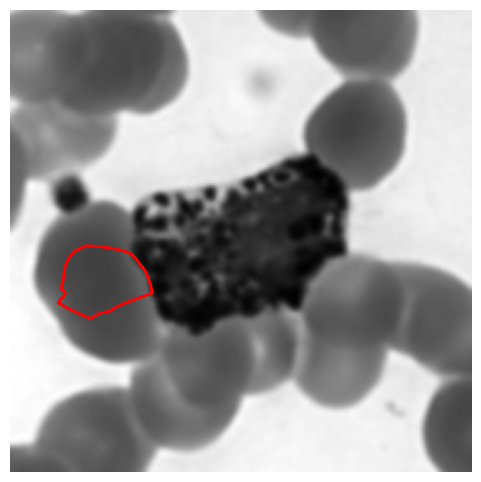

In [274]:
img_to_seg        = img_cell

# 1st SEG: To segment left cell
r0 = 150; c0=50; R0 = 20
alpha_val = 0.01 ; beta_val = 0.1 ;gamma_val = 0.01; convergence_val = 1e-4; Niter_snake = 200;

# Pre smooth the image
Niter_smooth = 1
img_to_seg   = gaussian(img_to_seg, Niter_smooth, preserve_range=False)

# Initialise contour
init = define_initial_circle(R0,r0,c0)

# Run active contour while saving intermediate contours to see deformations
segs = []
print('start')
for i in range(1,Niter_snake,10):
    print(i, " ", end='')
    segs.append(active_contour(img_to_seg, init, max_num_iter=i, convergence=convergence_val,
                alpha=alpha_val, beta=beta_val, gamma=gamma_val))

print('stop')
np.save('ANIM_contours.npy', np.array(segs))

# display animation
segs = np.load('ANIM_contours.npy')
anim = animate_snake(img_to_seg, segs);
HTML(anim.to_html5_video())

## Answer 2

### 1

When using the given intialisation of the circle totally inside the darkest cell, We noitice that after 200 iteration the snake is nowhere near the desired solution. The snake is highly influenced by the undesired gradient forces coming from the noise. Thus it struggles to get past it and gets stuck.

After trying the optimal intialization ( circle not entirly inside the cell) and increase the gaussien kernel, we get much better results for the same hyperparameters and same number of iteration (even though it still needs more than that to give us the desired result). By incresing the guassien parameter we havely reduce the impact of the noise in the image and smouth the inside zone of the cell. This enables the sanke to avoid being trapped in false contours due to the previously high values.

start
1  11  21  31  41  51  61  71  81  91  101  111  121  131  141  151  161  171  181  191  stop


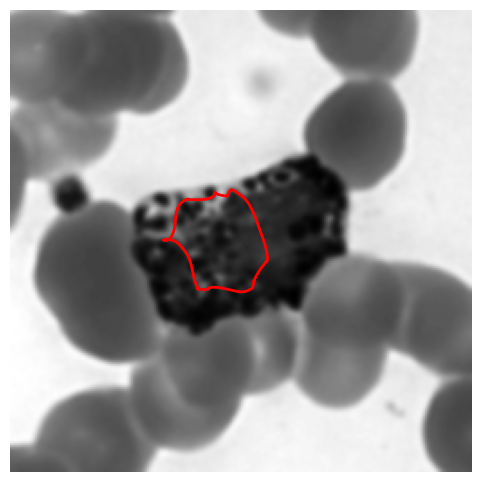

In [275]:
img_to_seg        = img_cell

# 2nd SEG: To segment center dark cell
r0 = 130; c0=120; R0 = 30 # initialise inside

alpha_val = 0.01 ; beta_val = 0.1 ;gamma_val = 0.01; convergence_val = 1e-4; Niter_snake = 200;

# Pre smooth the image
Niter_smooth = 1
img_to_seg   = gaussian(img_to_seg, Niter_smooth, preserve_range=False)

# Initialise contour
init = define_initial_circle(R0,r0,c0)


# Run active contour while saving intermediate contours to see deformations
segs = []
print('start')
for i in range(1,Niter_snake,10):
    print(i, " ", end='')
    segs.append(active_contour(img_to_seg, init, max_num_iter=i, convergence=convergence_val,
                alpha=alpha_val, beta=beta_val, gamma=gamma_val))

print('stop')
np.save('ANIM_contours.npy', np.array(segs))

# display animation
segs = np.load('ANIM_contours.npy')
anim = animate_snake(img_to_seg, segs);
HTML(anim.to_html5_video())

start
1  11  21  31  41  51  61  71  81  91  101  111  121  131  141  151  161  171  181  191  stop


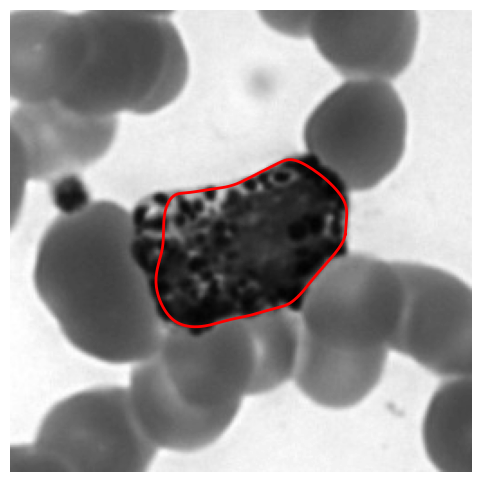

In [276]:
img_to_seg        = img_cell

# 2nd SEG: To segment center dark cell
r0,c0,R0 = get_inital_circl_param (img_to_seg)

alpha_val = 0.01 ; beta_val = 0.1 ;gamma_val = 0.01; convergence_val = 1e-4; Niter_snake = 200;

# Pre smooth the image
Niter_smooth = 8
img_to_seg   = gaussian(img_to_seg, Niter_smooth, preserve_range=False)

# Initialise contour
init = define_initial_circle(R0,r0,c0)


# Run active contour while saving intermediate contours to see deformations
segs = []
print('start')
for i in range(1,Niter_snake,10):
    print(i, " ", end='')
    segs.append(active_contour(img_to_seg, init, max_num_iter=i, convergence=convergence_val,
                alpha=alpha_val, beta=beta_val, gamma=gamma_val))

print('stop')
np.save('ANIM_contours.npy', np.array(segs))

# display animation
segs = np.load('ANIM_contours.npy')
anim = animate_snake(img_cell, segs);
HTML(anim.to_html5_video())

# Seg # 4

### Snake with  Gradient Vector Flow (GVF)
This implementation of the GVF is performed by computing the edge map, diffusing the gradient over the whole image and directly input the GVF_edge_map to be used as external forces by setting w_line=1 and w_edge=0 in the active_contour function.

## TODO:

1. Compare results when segmenting the Edge_map or GVF_map as input to the active_contour routine on 3 images: img_star, img_star_noisy and an image of your choice. Comment on robustness and speed differences.
1. When using GVF_map, test the effect of decreasing by a factor of 10 alpha,beta or gamma and interpret the effect.

## Answer 1

### Segmenting using Edge_map

In [277]:
Images_titles =["image star","image star noisy", "my image"]
Images_Edge_map =[]

#### Image star

start
1  11  21  31  41  51  61  71  81  91  101  111  121  131  141  151  161  171  181  191  201  211  221  231  241  251  261  271  281  291  301  311  321  331  341  351  361  371  381  391  stop


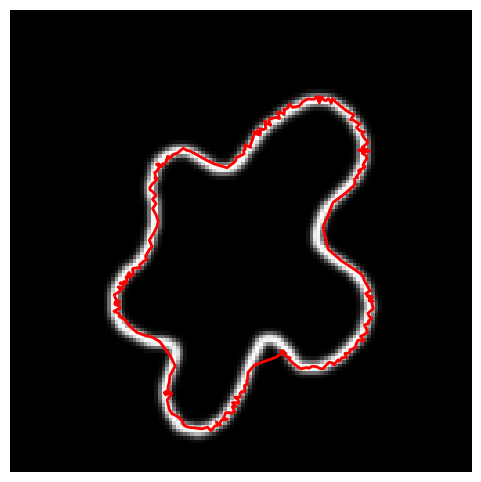

In [278]:
# Image to seg
img_to_seg = img_star
r0 = 64; c0=64; R0 = 50

alpha_val  = 0.01 ; beta_val = 0.1; gamma_val = 0.01;
convergence_val = 1e-4; Niter_snake = 400;


# Initialise contour
init        = define_initial_circle(R0,r0,c0,Nber_pts=400)

# Compute edge map and gvf
img_to_seg = img_to_seg.astype(np.float32) / np.max(img_to_seg)
Edge_map   = edge_map(img_to_seg,sigma=1)

# Run active contour while saving intermediate contours to see deformations
Map_to_seg = Edge_map

# Run active contour while saving intermediate contours to see deformations
segs = []
print('start')
for i in range(1,Niter_snake,10):
    print(i, " ", end='')
    segs.append(active_contour(Edge_map, init, max_num_iter=i, convergence=convergence_val,
                alpha=alpha_val, beta=beta_val, gamma=gamma_val,
                    w_line=1,w_edge=0))
Images_Edge_map.append( segs[-1])
print('stop')
np.save('ANIM_contours.npy', np.array(segs))

# display animation
segs = np.load('ANIM_contours.npy')
anim = animate_snake(Map_to_seg, segs);
HTML(anim.to_html5_video())

#### Image star noisy

start
1  11  21  31  41  51  61  71  81  91  101  111  121  131  141  151  161  171  181  191  201  211  221  231  241  251  261  271  281  291  301  311  321  331  341  351  361  371  381  391  stop


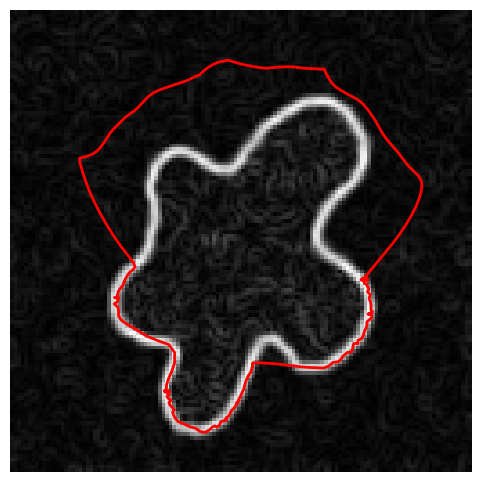

In [279]:
# Image to seg
img_to_seg = img_star_noisy
r0 = 64; c0=64; R0 = 50

alpha_val  = 0.01 ; beta_val = 0.1; gamma_val = 0.01;
convergence_val = 1e-4; Niter_snake = 400;


# Initialise contour
init        = define_initial_circle(R0,r0,c0,Nber_pts=400)

# Compute edge map and gvf
img_to_seg = img_to_seg.astype(np.float32) / np.max(img_to_seg)
Edge_map   = edge_map(img_to_seg,sigma=1)

# Run active contour while saving intermediate contours to see deformations
Map_to_seg = Edge_map

# Run active contour while saving intermediate contours to see deformations
segs = []
print('start')
for i in range(1,Niter_snake,10):
    print(i, " ", end='')
    segs.append(active_contour(Edge_map, init, max_num_iter=i, convergence=convergence_val,
                alpha=alpha_val, beta=beta_val, gamma=gamma_val,
                    w_line=1,w_edge=0))
Images_Edge_map.append( segs[-1])
print('stop')
np.save('ANIM_contours.npy', np.array(segs))

# display animation
segs = np.load('ANIM_contours.npy')
anim = animate_snake(Map_to_seg, segs);
HTML(anim.to_html5_video())

#### My image

start
1  11  21  31  41  51  61  71  81  91  101  111  121  131  141  151  161  171  181  191  201  211  221  231  241  251  261  271  281  291  301  311  321  331  341  351  361  371  381  391  stop


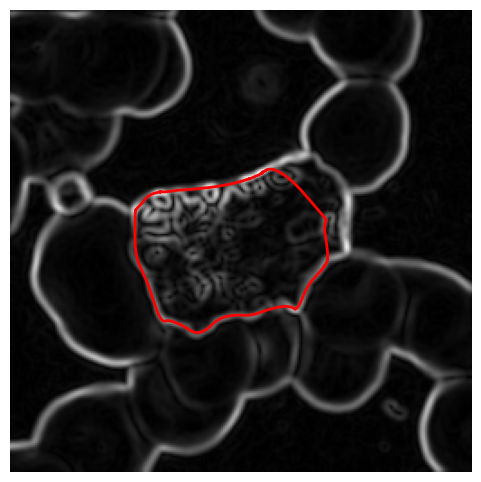

In [280]:
# Image to seg

img_to_seg = img_cell
r0 = 130; c0=120; R0 = 50

alpha_val  = 0.01 ; beta_val = 0.1; gamma_val = 0.01;
convergence_val = 1e-4; Niter_snake = 400;


# Initialise contour
init        = define_initial_circle(R0,r0,c0,Nber_pts=400)

# Compute edge map and gvf
img_to_seg = img_to_seg.astype(np.float32) / np.max(img_to_seg)
Edge_map   = edge_map(img_to_seg,sigma=1)

# Run active contour while saving intermediate contours to see deformations
Map_to_seg = Edge_map

# Run active contour while saving intermediate contours to see deformations
segs = []
print('start')
for i in range(1,Niter_snake,10):
    print(i, " ", end='')
    segs.append(active_contour(Edge_map, init, max_num_iter=i, convergence=convergence_val,
                alpha=alpha_val, beta=beta_val, gamma=gamma_val,
                    w_line=1,w_edge=0))
Images_Edge_map.append(segs[-1])
print('stop')
np.save('ANIM_contours.npy', np.array(segs))

# display animation
segs = np.load('ANIM_contours.npy')
anim = animate_snake(Map_to_seg, segs);
HTML(anim.to_html5_video())

### Segmenting using GVF

In [281]:
Images_GVF_map =[]

In [282]:
import gvf_elsa2
from gvf_elsa2 import  gradient_field
import sys
## the given implementation in the gvf_elsa2 has an error. This is the corrected version
def gradient_vector_flow(fx, fy, mu, dx=1.0, dy=1.0, verbose=True):
    u'''calc gradient vector flow of input gradient field fx, fy'''
    # calc some coefficients.
    b = fx**2.0 + fy**2.0
    c1, c2 = b*fx, b*fy
    # calc dt from scaling parameter r.
    r = 0.25 # (17) r < 1/4 required for convergence.
    dt = r*dx*dy/(mu) ## This is the line that contains the error
    # max iteration
    N = int(max(1, np.sqrt(fx.shape[0]*fx.shape[1])))
    # initialize u(x, y), v(x, y) by the input.
    curr_u = fx
    curr_v = fy
    def laplacian(m):
        return np.hstack([m[:, 0:1], m[:, :-1]]) + np.hstack([m[:, 1:], m[:, -2:-1]]) \
                + np.vstack([m[0:1, :], m[:-1, :]]) + np.vstack([m[1:, :], m[-2:-1, :]]) \
                - 4*m
    for i in range(N):
        next_u = (1.0 - b*dt)*curr_u + r*laplacian(curr_u) + c1*dt
        next_v = (1.0 - b*dt)*curr_v + r*laplacian(curr_v) + c2*dt
        curr_u, curr_v = next_u, next_v
        if verbose:
            sys.stdout.write('.')
            sys.stdout.flush()
    if verbose:
        sys.stdout.write('\n')
    return curr_u, curr_v



#### Image star

First, we will see the influence of mu on the obtained field

As we saw in course, the value of µ reflects the trade off between the smoothness of the GVF field and its ressemblance to the given Edge-map. The lower the value of µ the more ressmablance we get. This is also confirmed in the following code cell. In fact for low values of µ w get almost the same edge-map and the GVF algorithm favours being close to data since the smoothness term has a small coefficient (µ). For higher values of µ we get smoother fields that ressemblance less and less the given Edge-map but also conservers the overall allure

In [283]:
mus = [0.2,0.25,0.3,0.4,0.5,1,1.5,2,3,4,5,10,20,50,100]
GVFs =[]
img_to_seg=img_star
img_to_seg = img_to_seg.astype(np.float32) / np.max(img_to_seg)
Edge_map   = edge_map(img_to_seg,sigma=1)
fx, fy = gradient_field(img_to_seg)

for mu in mus :
  gx, gy = gradient_vector_flow(fx, fy, mu=mu,verbose=False)
  GVF_map = np.sqrt(gx**2 + gy**2)
  GVFs.append(GVF_map)

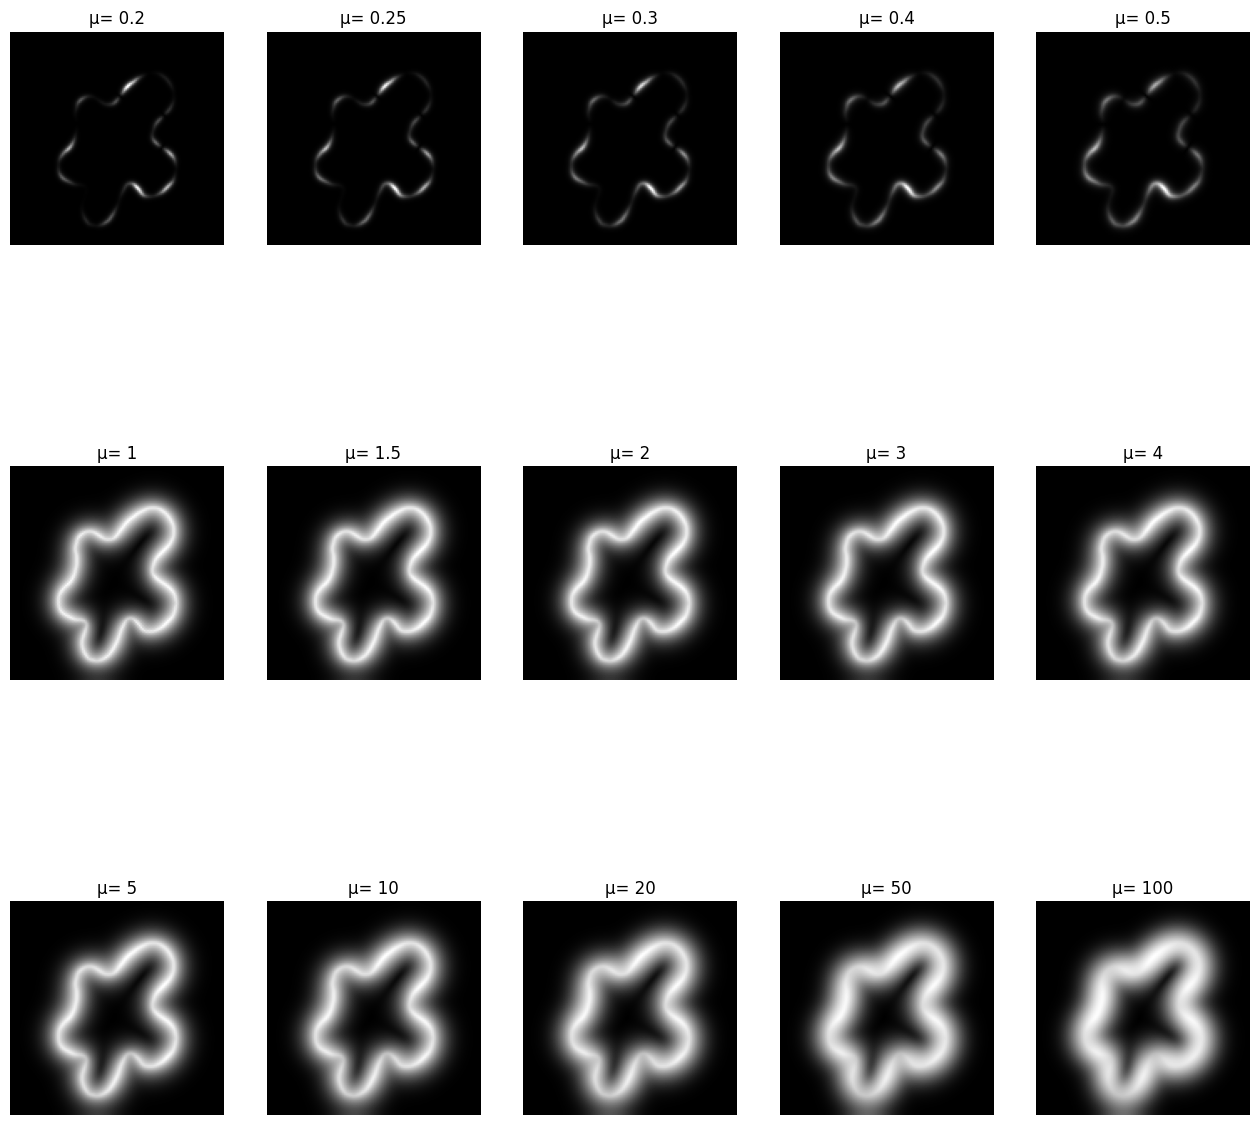

In [284]:
fig,ax = plt.subplots(3,5,figsize=(16,16))
for i in range (3):
  for j in range (5):
    ax[i,j].imshow(GVFs[5*i+j],cmap='gray');
    ax[i,j].set_title(f"µ= {mus[5*i+j]}");
    ax[i,j].axis("off");
plt.show();


Now, let's move on to using the obtained field in our active contour

................................................................................................................................


Text(0.5, 1.0, 'GVF_map')

start
1  11  21  31  41  51  61  71  81  91  101  111  121  131  141  151  161  171  181  191  stop


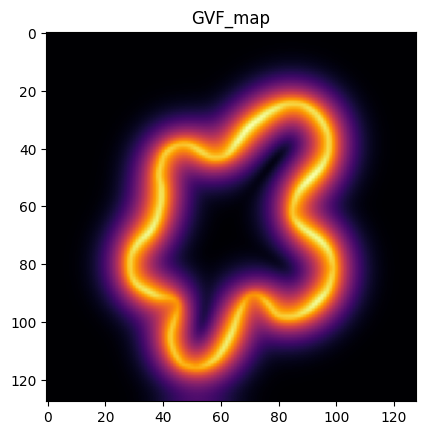

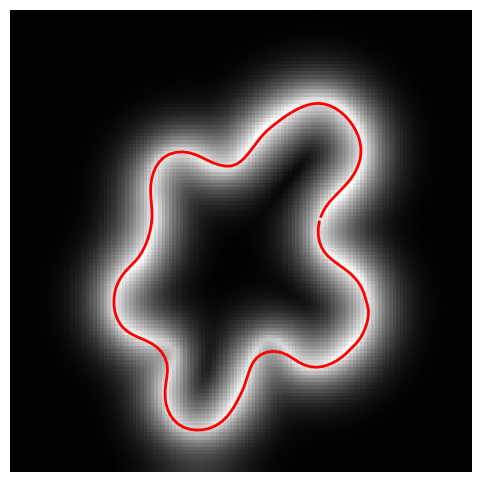

In [285]:
# Image to seg
img_to_seg = img_star
r0 = 64; c0=64; R0 = 50

alpha_val  = 0.01 ; beta_val = 0.1; gamma_val = 0.01;
convergence_val = 1e-4; Niter_snake = 200;


# Initialise contour
init        = define_initial_circle(R0,r0,c0,Nber_pts=400)

# Compute edge map and gvf
img_to_seg = img_to_seg.astype(np.float32) / np.max(img_to_seg)
Edge_map   = edge_map(img_to_seg,sigma=1)

fx, fy = gradient_field(img_to_seg) # ELSA CORRECTED - was calling with Edge_map as input
gx, gy = gradient_vector_flow(fx, fy, mu=5)
GVF_map = np.sqrt(gx**2 + gy**2)

plt.imshow(GVF_map, cmap="inferno")
plt.title("GVF_map")
# Run active contour while saving intermediate contours to see deformations
Map_to_seg = GVF_map

# Run active contour while saving intermediate contours to see deformations
segs = []
print('start')
for i in range(1,Niter_snake,10):
    print(i, " ", end='')
    init=active_contour(GVF_map, init, max_num_iter=i, convergence=convergence_val,
                alpha=alpha_val, beta=beta_val, gamma=gamma_val,
                    w_line=1,w_edge=0)
    segs.append(init)
Images_GVF_map.append(segs[-1])
print('stop')
np.save('ANIM_contours.npy', np.array(segs))

# display animation
segs = np.load('ANIM_contours.npy')
anim = animate_snake(Map_to_seg, segs);
HTML(anim.to_html5_video())

#### Image noisy_star

................................................................................................................................
start
1  11  21  31  41  51  61  71  81  91  101  111  121  131  141  151  161  171  181  191  stop


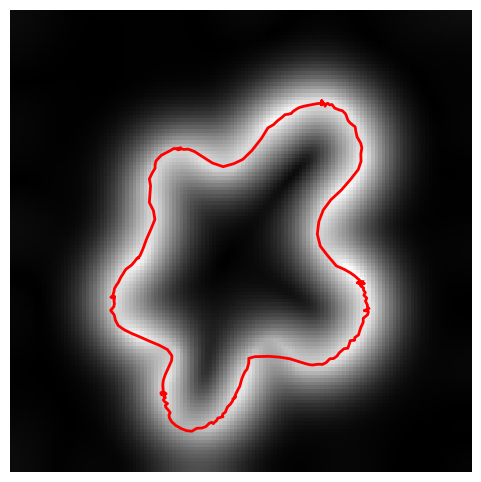

In [286]:
# Image to seg
img_to_seg = img_star_noisy
r0 = 64; c0=64; R0 = 50

alpha_val  = 0.01 ; beta_val = 0.1; gamma_val = 0.01;
convergence_val = 1e-4; Niter_snake = 200;


# Initialise contour
init        = define_initial_circle(R0,r0,c0,Nber_pts=400)

# Compute edge map and gvf
img_to_seg = img_to_seg.astype(np.float32) / np.max(img_to_seg)
Edge_map   = edge_map(img_to_seg,sigma=1)

fx, fy = gradient_field(img_to_seg) # ELSA CORRECTED - was calling with Edge_map as input
gx, gy = gradient_vector_flow(fx, fy, mu=5)
GVF_map = np.sqrt(gx**2 + gy**2)

# Run active contour while saving intermediate contours to see deformations
Map_to_seg = GVF_map

# Run active contour while saving intermediate contours to see deformations
segs = []
print('start')
for i in range(1,Niter_snake,10):
    print(i, " ", end='')
    init=active_contour(Edge_map, init, max_num_iter=i, convergence=convergence_val,
                alpha=alpha_val, beta=beta_val, gamma=gamma_val,
                    w_line=1,w_edge=0)
    segs.append(init)
Images_GVF_map.append(segs[-1])
print('stop')
np.save('ANIM_contours.npy', np.array(segs))

# display animation
segs = np.load('ANIM_contours.npy')
anim = animate_snake(Map_to_seg, segs);
HTML(anim.to_html5_video())

#### My image

................................................................................................................................................................................................................................................................
start
1  11  21  31  41  51  61  71  81  91  101  111  121  131  141  151  161  171  181  191  stop


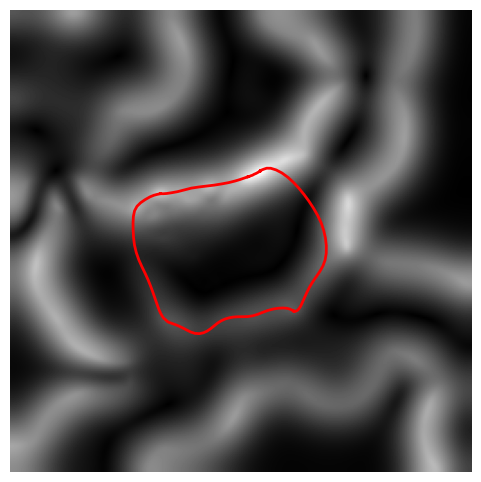

In [287]:
# Image to seg
img_to_seg = img_cell
r0 = 130; c0=120; R0 = 50

alpha_val  = 0.01 ; beta_val = 0.1; gamma_val = 0.01;
convergence_val = 1e-4; Niter_snake = 200;


# Initialise contour
init        = define_initial_circle(R0,r0,c0,Nber_pts=400)

# Compute edge map and gvf
img_to_seg = img_to_seg.astype(np.float32) / np.max(img_to_seg)
Edge_map   = edge_map(img_to_seg,sigma=1)

fx, fy = gradient_field(img_to_seg) # ELSA CORRECTED - was calling with Edge_map as input
gx, gy = gradient_vector_flow(fx, fy, mu=10)
GVF_map = np.sqrt(gx**2 + gy**2)

# Run active contour while saving intermediate contours to see deformations
Map_to_seg = GVF_map

# Run active contour while saving intermediate contours to see deformations
segs = []
print('start')
for i in range(1,Niter_snake,10):
    print(i, " ", end='')
    init=active_contour(Edge_map, init, max_num_iter=i, convergence=convergence_val,
                alpha=alpha_val, beta=beta_val, gamma=gamma_val,
                    w_line=1,w_edge=0)
    segs.append(init)
Images_GVF_map.append(segs[-1])
print('stop')
np.save('ANIM_contours.npy', np.array(segs))

# display animation
segs = np.load('ANIM_contours.npy')
anim = animate_snake(Map_to_seg, segs);
HTML(anim.to_html5_video())

### Comparaison

As shown below, In most cases GVF fields performs exceptionally better. Several properties can be observed through this comparaison. First, the capture ranges of the GVF force field is clearly much larger than that of the Edge-map. The second image illustrates this property. In fact, the GVF forces will attract the snake if it is in a smooth area far from the edge. Second, The first image, shows that this field yields much smoother contour due to its external forces being smoothed out. The last image, shows that in some cases, the GVF can perform in the same manner as the Edge-map when given a very close initalization and a noisy non-smooth areas.

Overall, the GVF is more robust to intialization : We can get pretty good results even when the intialization is considerably far from the desired output. Also it is robust to image noise due to the smoothining factor in the energy expression.

In terms of speed, even though we needed more computation in order to get the external forces, This time was compensated by the speed of convergence of the snake algorithm. In fact, we find the solution in much less steps since the hole snake is constrainted to external forces. In opposition to the Edge-map where we had to wait for some parts to find the edge and induce the changes via the regularisation of the form of the snake

images obtained by using Edge-map as input for the snake


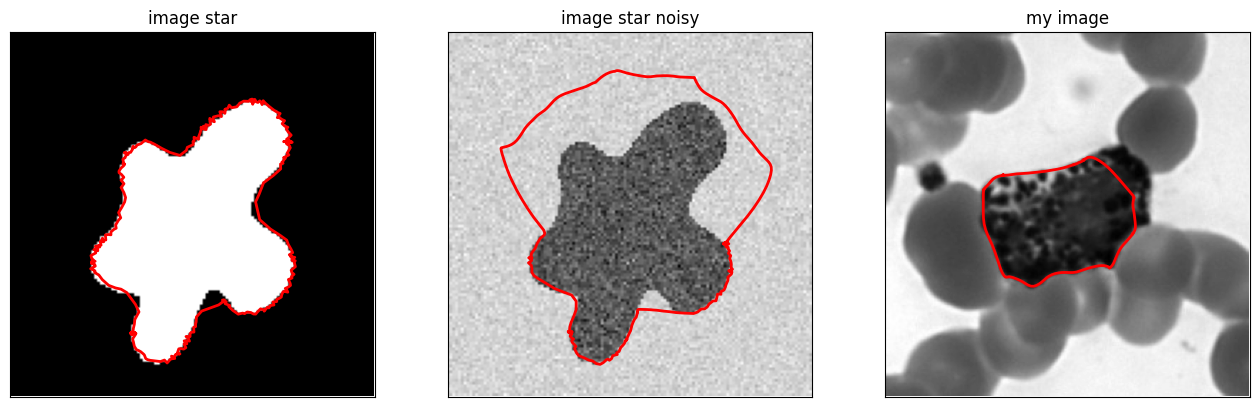

images obtained by using GVF field as input for the snake


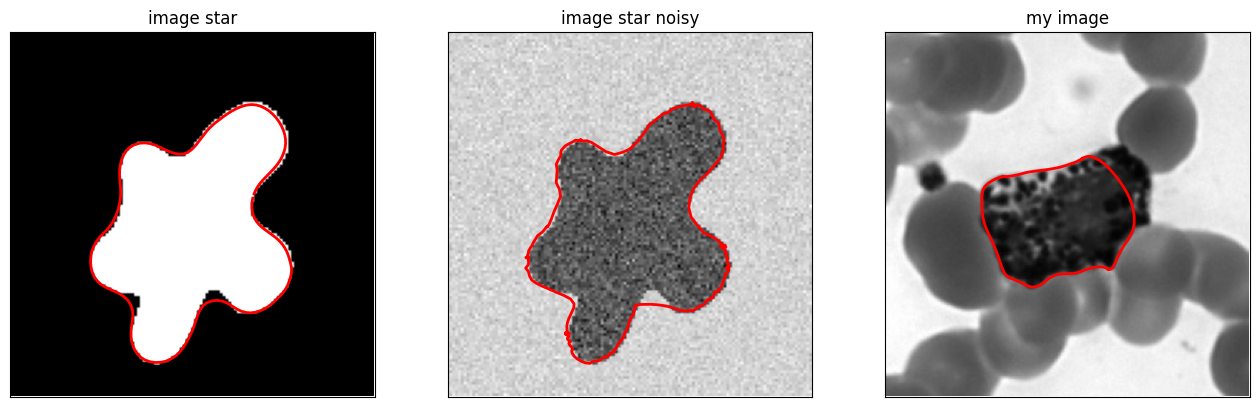

In [288]:
print("images obtained by using Edge-map as input for the snake")
images_to_seg=[img_star,img_star_noisy,img_cell]
fig,ax=plt.subplots(1,3,figsize=(16,16))
for i in range(3):
  ax[i].imshow(images_to_seg[i], cmap="gray");
  ax[i].plot(Images_Edge_map[i][:, 1], Images_Edge_map[i][:, 0], '-r', lw=2);
  ax[i].set_xticks([]), ax[i].set_yticks([]);
  ax[i].axis([0, images_to_seg[i].shape[1], images_to_seg[i].shape[0], 0]);
  ax[i].set_title(Images_titles[i]);
#fig.suptitle('Using Edge-map')
plt.show();

print("images obtained by using GVF field as input for the snake")

fig,ax=plt.subplots(1,3,figsize=(16,16))
for i in range(3):
  ax[i].imshow(images_to_seg[i], cmap="gray");
  ax[i].plot(Images_GVF_map[i][:, 1], Images_GVF_map[i][:, 0], '-r', lw=2);
  ax[i].set_xticks([]), ax[i].set_yticks([]);
  ax[i].axis([0, images_to_seg[i].shape[1], images_to_seg[i].shape[0], 0]);
  ax[i].set_title(Images_titles[i]);
#fig.suptitle('Using Edge-map')
plt.show();



## Answer 2

In [289]:
# values to test
alpha_vals =[1,0.08,0.01,0.001,0.001]
beta_vals = [100,0.8,0.1,0.01,0]
gamma_vals =[0.01,0.008,0.005,0.0025,0.001]

### Influence of alpha

As we described in the first question, Alpha influences on the length of the snake. For the same value of beta and gamma, the higher the value of alpha the more our snake tends to have a lower length. In the example that follows it is clear that for the first value alpha =1 has the fastest contraction after 10 iterations (green contour) compared to the others. Also, the final contour has little bends and line segments when possible because they have lower length and the algorithm is sensetive to changes in this range of values of alpha.

As we decrease the value of alpha the final shape tolerates more the curves that increase its length.

In [290]:
 # Image to seg
img_to_seg = img_star
r0 = 64; c0=64; R0 = 50

alpha_val  = 0.01 ; beta_val = 0.1; gamma_val = 0.01;

convergence_val = 1e-4; Niter_snake = 800;

# Initialise contour
init        = define_initial_circle(R0,r0,c0,Nber_pts=400)

# Compute edge map and gvf
img_to_seg = img_to_seg.astype(np.float32) / np.max(img_to_seg)
Edge_map   = edge_map(img_to_seg,sigma=1)

fx, fy = gradient_field(img_to_seg) # ELSA CORRECTED - was calling with Edge_map as input
gx, gy = gradient_vector_flow(fx, fy, mu=5)
GVF_map = np.sqrt(gx**2 + gy**2)

# Run active contour while saving intermediate contours to see deformations
Map_to_seg = GVF_map

# Run active contour while saving intermediate contours to see deformations
snakes10= []
snakes_max =[]
for i in range (5):
  snake10 = active_contour(Map_to_seg,
                        init, max_num_iter=10, convergence=convergence_val,
                          alpha=alpha_vals[i], beta=beta_val, gamma=gamma_val)
  snake_max = active_contour(Map_to_seg,
                        init, max_num_iter=Niter_snake, convergence=convergence_val,
                            alpha=alpha_vals[i], beta=beta_val, gamma=gamma_val)
  snakes10.append(snake10)
  snakes_max.append(snake_max)

................................................................................................................................


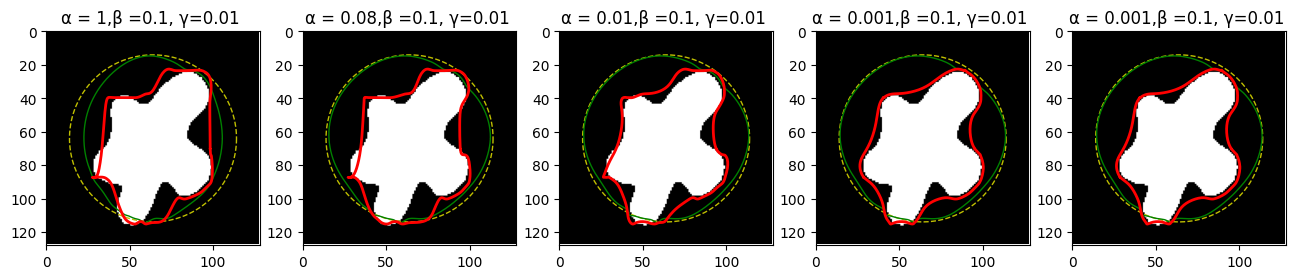

In [291]:
# Display results
fig, ax = plt.subplots(1,5,figsize=(16, 16));

for i in range (5):
  ax[i].imshow(img_to_seg, cmap=plt.cm.gray);
  ax[i].plot(init[:, 1], init[:, 0], '--y', lw=1);
  ax[i].plot(snakes10[i][:, 1], snake10[:, 0], '-g', lw=1);
  ax[i].plot(snakes_max[i][:, 1], snake_max[:, 0], '-r', lw=2);
  ax[i].axis([0, img_to_seg.shape[1], img_to_seg.shape[0], 0]);
  ax[i].set_title(f"α = {alpha_vals[i]},β ={beta_val}, γ={gamma_val} ")

plt.show();

### Influence of beta

For beta, the influence of this parameters is insegnificant when comparing results for 1-> 0 even the 0 value yields almost the same segmentation with 0.8 value. In order to see the impact of this parameter I added a beta value of 100 in order to show that this parameter influences the tolerance of the snake to bending forces and that the contour will avoid bending at all for high values like in the first image (beta =100)

In [292]:
 # Image to seg
img_to_seg = img_star
r0 = 64; c0=64; R0 = 50

alpha_val  = 0.01 ; beta_val = 0.1; gamma_val = 0.01;

convergence_val = 1e-4; Niter_snake = 800;

# Initialise contour
init        = define_initial_circle(R0,r0,c0,Nber_pts=400)

# Compute edge map and gvf
img_to_seg = img_to_seg.astype(np.float32) / np.max(img_to_seg)
Edge_map   = edge_map(img_to_seg,sigma=1)

fx, fy = gradient_field(img_to_seg) # ELSA CORRECTED - was calling with Edge_map as input
gx, gy = gradient_vector_flow(fx, fy, mu=5)
GVF_map = np.sqrt(gx**2 + gy**2)

# Run active contour while saving intermediate contours to see deformations
Map_to_seg = GVF_map

# Run active contour while saving intermediate contours to see deformations
snakes10= []
snakes_max =[]
for i in range (5):
  snake10 = active_contour(Map_to_seg,
                        init, max_num_iter=10, convergence=convergence_val,
                          alpha=alpha_val, beta=beta_vals[i], gamma=gamma_val)
  snake_max = active_contour(Map_to_seg,
                        init, max_num_iter=Niter_snake, convergence=convergence_val,
                            alpha=alpha_val, beta=beta_vals[i], gamma=gamma_val)
  snakes10.append(snake10)
  snakes_max.append(snake_max)

................................................................................................................................


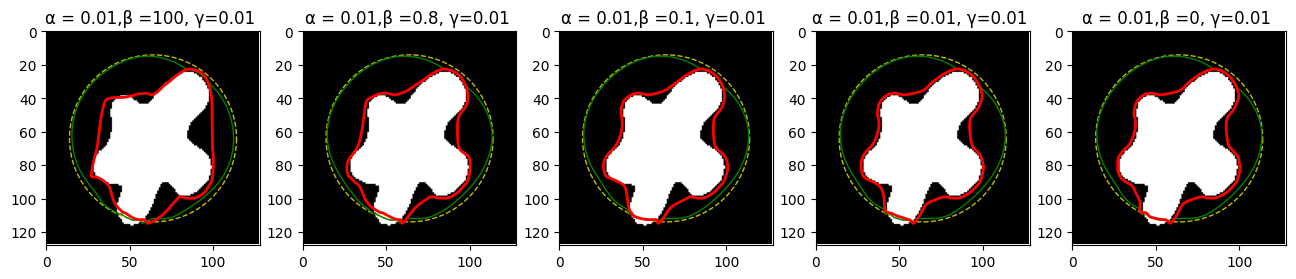

In [293]:
# Display results
fig, ax = plt.subplots(1,5,figsize=(16, 16));

for i in range (5):
  ax[i].imshow(img_to_seg, cmap=plt.cm.gray);
  ax[i].plot(init[:, 1], init[:, 0], '--y', lw=1);
  ax[i].plot(snakes10[i][:, 1], snake10[:, 0], '-g', lw=1);
  ax[i].plot(snakes_max[i][:, 1], snake_max[:, 0], '-r', lw=2);
  ax[i].axis([0, img_to_seg.shape[1], img_to_seg.shape[0], 0]);
  ax[i].set_title(f"α = {alpha_val},β ={beta_vals[i]}, γ={gamma_val} ")

plt.show();

### Influence of gamma

Even though, after 800 iterations the snake finds the solution everytime in this case , we see that the results speed depends on the range of values for gamma. For high values, the snake takes more steps to reach the solution. This is clear for the snake position after 10 iterations (the green line).

In [294]:
 # Image to seg
img_to_seg = img_star
r0 = 64; c0=64; R0 = 50

alpha_val  = 0.01 ; beta_val = 0.1; gamma_val = 0.01;

convergence_val = 1e-4; Niter_snake = 800;

# Initialise contour
init        = define_initial_circle(R0,r0,c0,Nber_pts=400)

# Compute edge map and gvf
img_to_seg = img_to_seg.astype(np.float32) / np.max(img_to_seg)
Edge_map   = edge_map(img_to_seg,sigma=1)

fx, fy = gradient_field(img_to_seg) # ELSA CORRECTED - was calling with Edge_map as input
gx, gy = gradient_vector_flow(fx, fy, mu=5)
GVF_map = np.sqrt(gx**2 + gy**2)

# Run active contour while saving intermediate contours to see deformations
Map_to_seg = GVF_map

# Run active contour while saving intermediate contours to see deformations
snakes10= []
snakes_max =[]
for i in range (5):
  snake10 = active_contour(Map_to_seg,
                        init, max_num_iter=10, convergence=convergence_val,
                          alpha=alpha_val, beta=beta_val, gamma=gamma_vals[i])
  snake_max = active_contour(Map_to_seg,
                        init, max_num_iter=Niter_snake, convergence=convergence_val,
                            alpha=alpha_val, beta=beta_val, gamma=gamma_vals[i])
  snakes10.append(snake10)
  snakes_max.append(snake_max)

................................................................................................................................


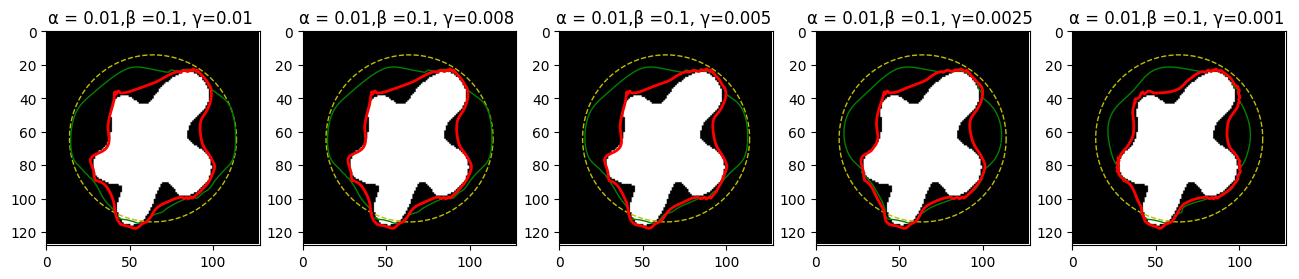

In [295]:
# Display results
fig, ax = plt.subplots(1,5,figsize=(16, 16));

for i in range (5):
  ax[i].imshow(img_to_seg, cmap=plt.cm.gray);
  ax[i].plot(init[:, 1], init[:, 0], '--y', lw=1);
  ax[i].plot(snakes10[i][:, 1], snake10[:, 0], '-g', lw=1);
  ax[i].plot(snakes_max[i][:, 1], snake_max[:, 0], '-r', lw=2);
  ax[i].axis([0, img_to_seg.shape[1], img_to_seg.shape[0], 0]);
  ax[i].set_title(f"α = {alpha_val},β ={beta_val}, γ={gamma_vals[i]} ")

plt.show();

# Seg # 5:

### The active contour with fixed end points
You will now run the active_contour with the option to maintain some points from the inital contour fixed. You are working now with the img_nodule which is an ultrasound showing different layers of tissue under the skin surface.

## TO DO:
* Write a loop to vary the initial line vertical position by few pixels and propose a method to aggregate final contours, like for example a probability edge map.
* BONUS: Propose and implement a metric to measure the "quality" of the segmented contour, as being representative of the "interface" between two tissues.


## 1

Since the active contour algorithm is fast, the idea is the following : I will run it 41 times with the initialization being perfectly horizental lines going from hight 160 to 240 with step =2. I chose these lines to have 780 points each, in order to get as much pixels as we have in the width. After running the algorithm we will obtain a new poistion of each point. This posistion corresponds to a potentially a good position for our segmentation. Then, I built up a probabilty array where each position will contain the number of pixels of the snake with the same indices. Then this array will be normalized. And thus we get a probabily edge map.

An other thing to note is that here I am supposing that there is only 2 tissues in this picture and the separating line is somewhere between the horizental lines with coordinate 160 and 240

In [296]:

positions =np.linspace(160,240,41)

img_to_seg = img_nodule

#r_left = 170; r_right=170; c_left=0; c_right = 780
#r_left = 200; r_right=190; c_left=0; c_right = 780
#r_left = 230; r_right=210; c_left=0; c_right = 780

alpha_val  = 0.01 ; beta_val = 0.1; gamma_val = 0.01;
convergence_val = 1e-4; Niter_snake = 500;
w_line_val=0; w_edge_val=1

# Pre smooth the image
img_to_seg   = skimage.exposure.equalize_adapthist(img_to_seg, clip_limit=0.03)
Niter_smooth = 1
img_to_seg   = gaussian(img_to_seg, Niter_smooth, preserve_range=False)


Nber_pts_contour = 780
c_left=0; c_right = 780
c = np.linspace(c_left, c_right-1, Nber_pts_contour)
snakes=[]
for pos in positions :
  r_left = pos
  r_right= pos
  # Initialise contour
  r          = np.linspace(r_left, r_right, Nber_pts_contour)
  init       = np.array([r, c]).T
  snake = active_contour(img_to_seg,
                        init, boundary_condition='fixed-fixed',max_num_iter=Niter_snake,
                        alpha=alpha_val, beta=beta_val, gamma=gamma_val,
                        w_line=w_line_val, w_edge=w_edge_val)
  snakes.append(snake)


Here is the probability of each point being a part of a certain snake. This image is shown in log2 scale since the values are low

max = 388.0, min = 0.0, mean = 0.5019551282051282, std = 5.786910186861987


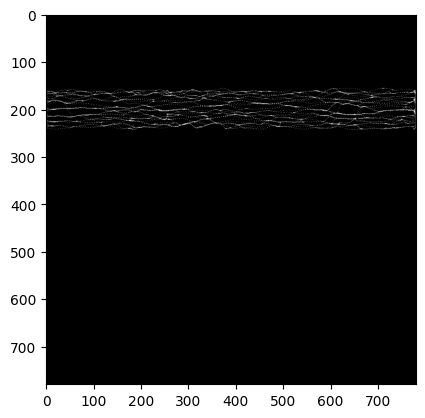

In [297]:
prob=np.zeros_like(img_to_seg)
for snake in snakes:
  for x,y in snake :
    prob [int(x),int(y)]+=1
print(f"max = {prob[160:240,:].max()}, min = {prob[160:240,:].min()}, mean = {prob[160:240,:].mean()}, std = {prob[160:240,:].std()}")
prob=prob/prob.sum()
plt.imshow(np.log(prob+1e-9),cmap="gray")

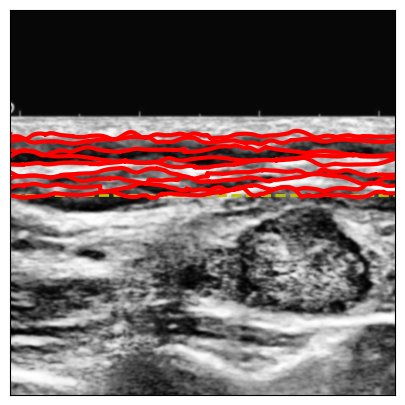

In [298]:
fig, ax = plt.subplots(figsize=(9, 5));
ax.imshow(img_to_seg[0:500,:], cmap=plt.cm.gray);
ax.plot(init[:, 1], init[:, 0], '--y', lw=2);
ax.set_xticks([]), ax.set_yticks([]);
ax.set(xlim=(0, 500));
for i in range (0,41,5):
  ax.plot(snakes[i][:, 1], snakes[i][:, 0], '-r', lw=3);
plt.show();

## 1-Bonus

An idea consists of taking the line and summing the probability of points being one of a given snake result. The resulting value will be between 0 and 1 and the higher it is the more likely we have a good separating line.

However this method does suffer from some limitation for instance we can take the best value in each raw in the proba array and it won't necceraly be something good.

In [299]:
def mesure (line, proba):
  res = 0
  unique = []
  for x,y in line :
    if((int(x),int(y)) not in unique ): #to avoid points being the same and still contribute to the result
      res += proba [int(x),int(y)]
    unique.append((int(x),int(y)))

  return res

In [300]:
print(mesure(snakes[0],prob),mesure(snakes[-1],prob))

0.05484677923702299 0.0628205128205126


# Seg # 6

### Your turn on proposing a motivated pipeline using the snake capabilities from the active_contour function

## TODO:
Choose a new image in the pool provided and propose a segmentation pipeline using the active_contour approach. Options on points to work on include: <br>
* Pre filter the image as you wish
* Manually or automatically position the initial contour
* Provide one segmentation result or merge several solutions in a probability map
* Detect issues in contour shape during deformations and propose an early stop criteria.

## preprocessing

For this task I chose to segement the darkest cell in the next image.
In the preprocessing step I noiticed that the most adequate is to use an opening filter. In fact, since we want to segment the exterior boundary of the cell using active snake, it would be helpful to reduce the fluctance inside it and seal the little changes. This will help reduce the gradient values inside the cell that are not relevant for our task. This will lead to better external forces representations later on.

Afterwards we compute the edge map

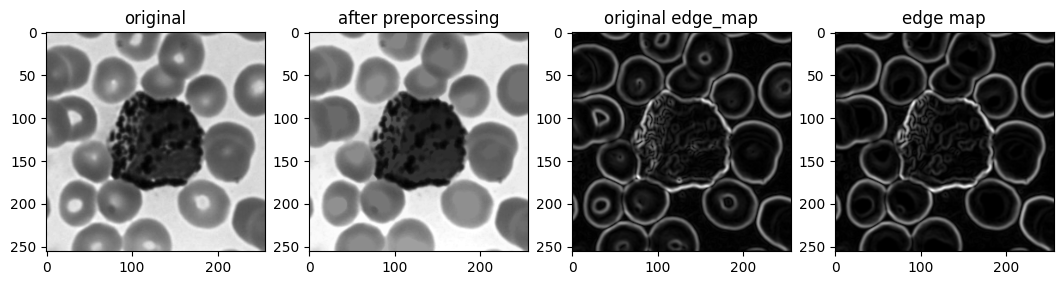

In [307]:
img = skimage.io.imread("images_blood_cells/000017.png",as_gray=True)
prep_img = skimage.morphology.diameter_opening(img, 40, connectivity=2)
edge = edge_map(prep_img,1)
fig,ax =plt.subplots(1,4,figsize=(13,13))
ax[1].imshow(prep_img,cmap='gray')
ax[0].set_title("original")
ax[0].imshow(img,cmap='gray')
ax[1].set_title("after preporcessing")

ax[3].imshow(edge,cmap="gray")
ax[3].set_title("edge map")

ax[2].imshow(edge_map(img,1),cmap="gray")
ax[2].set_title("original edge_map")
plt.show();

## Initialization

Now we have all what we need to proceed. I opted for a multiscale resolution. First I aim to get the overall shape of an initial snake. To do that I manually choose an initial circle and used the active contour algorithm with high value of beta in order to get a somewhat regid shape with no significant curvatures.And i ran the algorithm on the edge map with high gaussian kernel (sigma = 8).
This intial shape will serve as an initialization for an other run of the snake algorithm with a smaller value of beta. Here I know that my intialization is very close to the solution however it lacks the curvatures of the desired boundary so by setting a low beta I will tolerate to a certain degree the bending in my snake without changing its length. The obtained results are statisfying.

In [302]:
R0 = 60 ; r0 =130 ;c0=120;Niter = 1000; convergence_val = 1e-4;alpha= 0.01;beta = 1 ;gamma=0.1
init = define_initial_circle(R0,r0,c0,Nber_pts=500)

Map_to_seg = edge_map(prep_img,8)
init_snake=active_contour(Map_to_seg, init, max_num_iter=Niter, convergence=convergence_val,
            alpha=alpha_val, beta=beta_val, gamma=gamma_val,
                w_line=1,w_edge=0)



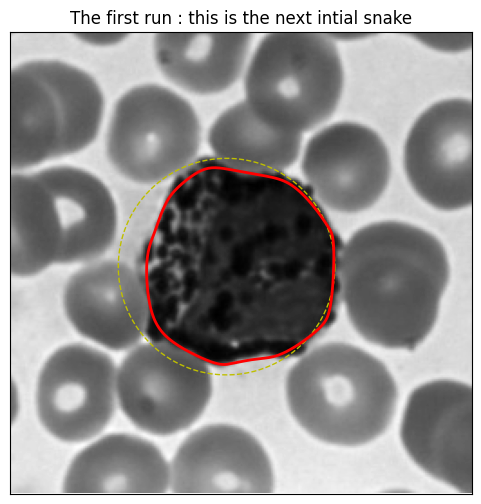

In [303]:

fig, ax = plt.subplots(figsize=(6, 6))
ax.imshow(img, cmap=plt.cm.gray)
ax.plot(init[:, 1], init[:, 0], '--y', lw=1)
ax.plot(init_snake[:, 1], init_snake[:, 0], '-r', lw=2)
ax.set_xticks([]), ax.set_yticks([])
ax.axis([0, img.shape[1], img.shape[0], 0])
ax.set_title("The first run : this is the next intial snake")
plt.show();

## Countour detection

Now I will use the video sequence to visualizae the changes and potentielly capture some limitation.

start
1  11  21  31  41  51  61  71  81  91  100  150  200  250  300  350  400  450  stop


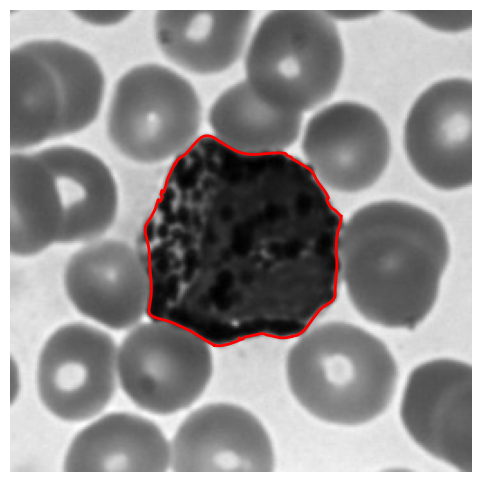

In [321]:
#alpha_val = 0.01 ; beta_val = 0.1 ;gamma_val = 0.01; convergence_val = 1e-4; Niter_snake = 200;
Niter = 500; convergence_val = 1e-4;alpha= 0.01;beta = 0.1 ;gamma=0.01

# Run active contour while saving intermediate contours to see deformations
segs = []

print('start')
for i in range(1,100,10):
    print(i, " ", end='')
    segs.append(active_contour(edge, init_snake, max_num_iter=i, convergence=convergence_val,
            alpha=alpha, beta=beta, gamma=gamma,w_line=1,w_edge=0))

for i in range(100,Niter,50):
    print(i, " ", end='')
    segs.append(active_contour(edge, init_snake, max_num_iter=i, convergence=convergence_val,
            alpha=alpha, beta=beta, gamma=gamma,w_line=1,w_edge=0))


print('stop')
np.save('ANIM_contours.npy', np.array(segs))

# display animation
segs = np.load('ANIM_contours.npy')
anim = animate_snake(img, segs);
HTML(anim.to_html5_video())

## Solution proposition

Overall, the segmentation results are good very close to the desired output. The only main issue is that even with selecting the convergence val small the algorithm still runs even if the snake remains the same. In fact, in the video, we see that after 0.10 there is no change at all in the snake. However we can't use the difference between 2 succive snakes since the change may occur after several steps. So the idea is to conseder a sequence of snakes for instance if over 10 succissve iterations the maximum difference in two snakes is less then a certain threshold we stop : if $max_{|i-j|<10} || snake_i-snake_j || < thresh$    we stop

# Seg #7

### Test on the Geometric Level-Set formulation using the Chan-Vese model.
Skimage provides two implementations of the Chan-Vese approach: **morphological_chan_vese** and **chan_vese**. <br>

The contours of ojects are now encoded in a level set function **Phi**.

The **initialisation** tested here is with a "checkerboard" pattern for 2 classes (object and background). <br>

For the **chan_vese** original implementation, the **hyper-parameters** include:<br>
* mu = 0.25 (default) | edge regularisation terms. Similar to ‘edge length’ weight parameter. Higher mu values will produce ‘smoother’ contours.
* dt = 0.5 (default) |  delta time step for each optimisation step.  
* lambda1=1, lambda2=1 (default) | weights in the cost metric to balance inside and outside homogeneity terms.
* tol=1e-3 (default) | Tolerance to test if the contours are "stable" and stop early.

The output contains: cv[0]=Seg and cv[1]=Phi <br>

For the **morphological_chan_vese**  implementation, the only **hyper-parameter** is the number of smoothing iterations (1 to 4 recommended).<br>

## TO DO:
1. C-V ori: Run the code on img_hela. Visualise and explain  evolution of Phi over first iterations. Figure out how to see the initial Phi configuration.
1. Run now on img_cell without and with pre-processing with histogram equalisation and explain difference in results.
1. Propose and implement method(s) and metrics to compare two segmentation results when handling segmentation masks. Use the one(s) implemented to quantify the differences obtained on one test case of your choice with the two implementations of chan-vese provided here.
1. Make the level set work when initialising with "disk" on img_MRIf


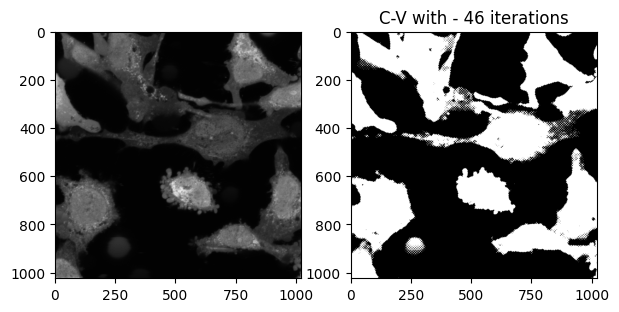

In [305]:

img_to_seg= img_hela

# PARAMETERS
mu_val=0.5 ; lambda1_val=1; lambda2_val=1; tol_val=1e-3; dt_val=0.5
smoothing_val = 3

Num_iter_cv_ori    = 100
Num_iter_cv_fast   = 1

CHAN_VESE_ORI  = 1
Init_method    = "checkerboard" # "checkerboard" or "disk" or "small disk" (alternative to use to set init_level_set)


# run segmentation
if CHAN_VESE_ORI == 1:
    # STANDARD implementation from original paper
    init_ls = checkerboard_level_set(img_to_seg.shape, 45)

    cv = chan_vese(img_to_seg, mu=mu_val, lambda1=lambda1_val, lambda2=lambda2_val,
                   tol=tol_val, dt=dt_val,
                   max_num_iter=Num_iter_cv_ori, init_level_set=Init_method,
                   extended_output=True)
    fig, ax = plt.subplots(1,2,figsize=(7, 7))
    ax[0].imshow(img_to_seg, cmap=plt.cm.gray)
    ax[1].imshow(1-cv[0], cmap=plt.cm.gray)
    title = f'C-V with - {len(cv[2])} iterations'
    ax[1].set_title(title, fontsize=12)

else:
    # FASTER implementation implemented with morphological operators BUT LESS PRECISE
    cv      = morphological_chan_vese(img_to_seg, num_iter=Num_iter_cv_fast,
                                      smoothing=smoothing_val, init_level_set="checkerboard")
    fig, ax = plt.subplots(1,2,figsize=(7, 7))
    ax[0].imshow(img_to_seg, cmap=plt.cm.gray)
    ax[1].imshow(1-cv, cmap=plt.cm.gray)
    title = f'C-V_morph with - {Num_iter_cv_fast} iterations'
    ax[1].set_title(title, fontsize=12)


plt.show();

# Seg # 8

## Geometric active contours with balloon force

You are now also provided with a tool to track the deformation patterns of the active contour over iterations. <br>

The geometric active contour routine is **morphological_geodesic_active_contour** which deforms a level set function with local speed values. It has the following **hyper-parameters** :<br>
* Thresh_cont_val  = 'auto'=> np.percentile(image, 40) (default if 'auto')  | pixels < Thresh_cont_val are considered borders. The evolution of the contour will stop on these pixels. Threshold_mask_balloon = image > threshold / np.abs(Balloon_weight)
* Balloon_weight   = 1 (default) | weight of the balloon force. Can be negative to inflate/deflat
* Smooth_cont_iter = 1 (default) |  Number of times a smoothing operator is applied per iteration


# TO DO:
* Segment the img_cell with the provided configuration in line 1 to inflate the initial contour. What is the issue?
* Now Segment the img_cell with the provided configuration in line 2 to deflate the initial contour. Adjust balloon parameter accordingly. Fix the issues observed to get a perfect segmentation in 30 iterations.
* Segment the img_MRIb image with the configuration in line 3 set to inflate an initial contour. Comment issues seen with high and low smoothness regularisation over 300 iterations.
* Now propose and run a setup to attempt to segment the gray matter contours in img_MRIb or some structure in another image. Comment on your choice of parameters, number of iterations and observed quality of contours.



0.7377611236173724


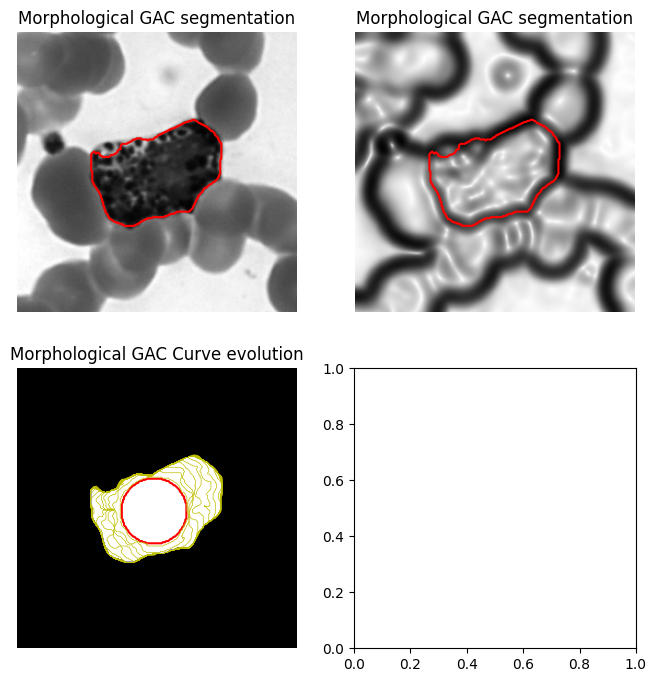

In [306]:


img_to_seg = img_cell ; r0 = 130;  c0 = 125 ; R0 = 30  # inflate
#img_to_seg = img_cell ; r0 = 130;  c0 = 125 ; R0 = 70  # deflate
#img_to_seg = img_MRIb ; r0 = 500 ; c0 = 530 ; R0 = 30  # for spine and inflate



SMOOTHING    = 0; Niter_smooth = 3
INV_EDGE_MAP = 1; # needed when using the Balloon force

img_ori    = img_to_seg

# Hyper parameters for snake and balloon
Thresh_cont_val  = 'auto' ; Balloon_weight   = 1 ; Smooth_cont_iter = 1 ;
Niter_snake      = 100

# smoothing
if SMOOTHING:
    img_to_seg = gaussian(img_to_seg, Niter_smooth, preserve_range=False)

# Test segment directly on edge image [QUESTION: WHY IS THE RESULT DIFFERENT?]
if INV_EDGE_MAP:
    img_to_seg = skimage.segmentation.inverse_gaussian_gradient(img_to_seg) # Compute the magnitude of the gradients in the image and then inverts the result in the range [0, 1]

#Print threshold used by "auto"
print(np.percentile(img_to_seg, 40))


# initialise call back
evolution = []
callback = store_evolution_in(evolution)

# Initialise contour
init_ls  = skimage.segmentation.disk_level_set(img_to_seg.shape, center=[r0,c0], radius=R0)

# Run geodesic active contour
ls       = morphological_geodesic_active_contour(
            img_to_seg, Niter_snake, init_ls,
            smoothing=Smooth_cont_iter, balloon=Balloon_weight,
            threshold=Thresh_cont_val,
            iter_callback=callback);


fig, axes = plt.subplots(2, 2, figsize=(8, 8));
ax = axes.flatten();

ax[0].imshow(img_ori, cmap="gray");
ax[0].set_axis_off();
ax[0].contour(ls, [0.5], colors='r');
ax[0].set_title("Morphological GAC segmentation", fontsize=12);

ax[1].imshow(img_to_seg, cmap="gray");
ax[1].set_axis_off();
ax[1].contour(ls, [0.5], colors='r');
ax[1].set_title("Morphological GAC segmentation", fontsize=12);

ax[2].imshow(ls, cmap="gray");
ax[2].set_axis_off();
contour = ax[2].contour(evolution[0], [0.5], colors='r');
contour.collections[0].set_label("Contours");
title = f'Morphological GAC Curve evolution';
ax[2].set_title(title, fontsize=12);
for i in range(1, Niter_snake-1, 5):
    contour = ax[2].contour(evolution[i], [0.01], linewidths=0.5, colors='y');

plt.show();